# Comparing causal bandits and classical bandits algorithms: Simulation on a simple contengency task




In [3]:
import networkx as nx
from typing import Callable, Union, Tuple, Dict, List, Optional
import scipy.stats as st
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.special as special
import warnings
import scipy
from scipy.stats import f_oneway
import numpy as np
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp
from scipy.stats import mannwhitneyu
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import levene
from statsmodels.stats.multicomp import MultiComparison

In [4]:
variable : Union[str, None] = None
structural_function : Callable[[Tuple[int, Union[int, None]]], int] 
structural_equations: Dict[str, Tuple[Callable[[Tuple[int, Union[int, None]]], int], Dict[str, Union[int, None]]]] = {}


## Structural Causal Model 

Structural Causal Model is defined by $<V, F, U, P(U)>$ where $V$ (resp. $U$) is the set of endogenous (resp. exogenous) variables; $F$ is the set of functional equations and $P(U)$ is the probability distribution over the exogenous variables. 

Methods: 

- *get_sample*: outputs a single random variate from the internal SCM

- *draw*: draw the causal graph associated with the internal SCM

- *build_causal_graph*: outputs a causal graph based on the input variable list and structural equations.

In [5]:
class StructuralCausalModel: 
    """
    Structural Causal Model for Causal Bandit implementation.
    """

    def __init__(
        self,
        variables: List[str], 
        structural_equations: Dict[str, Tuple[Callable[[Tuple[int, Union[int, None]]], int], Dict[str, Union[int, None]]]]
             
    ):
        """
        Instantiate StructuralCausalModel class.

        Parameters
        ----------

        variables: list[variable:str]
            List containing the name of the variables. 

        structural_equations: dict[variable: (func, list[variable:str])]
            A dictionary containing the structural relations between variables
            and their values. 

            
        """
        self.variables = variables # list of variables
        self.values = { var: None for var in variables } # list of values taken by each variable
        self.structural_equations = structural_equations # functions for each variable
        self.causal_graph = self.build_causal_graph(variables, structural_equations) # a causal graph of the SCM

    def build_causal_graph(
        self, 
        variables: List[str],
        structural_equations: Dict[str, Tuple[Callable[[Tuple[int, Union[int, None]]], int], Dict[str, Union[int, None]]]]
        ) -> nx.DiGraph: 

        """
        Build a causal graph from variables list and structural equations. 

        Parameters
        ----------
        variables: list[variable]
        structural_equations: dict[variable, eqution]

        Returns
        ----------
        a DiGraph

        """

        output_graph = nx.DiGraph()
        nodes = variables
        edges = []
        
        for variable, equation in structural_equations.items(): 
            children_node = variable
            (function, vars) = equation
            
            for var, value in vars.items():
                parent_node = var
                edges.append((parent_node, children_node))

        output_graph.add_nodes_from(nodes)
        output_graph.add_edges_from(edges)

        return output_graph

    def graph(self):
        """ Draw the internal causal graph
        """
        nx.draw(self.causal_graph)

    def get_sample(self, set_values: Optional[Union[Dict[str, int],None]] = None) -> dict[str, Union[int, None]]:
        """
        Sample from SCM (could be manipulated through set_values).

        Parameters
        ----------
        set_values: dict[variable, int]
            The values fixed by intervention on variables.

        Returns
        ----------
        output_assignements : dict[variable, int] 

        """


        output_assignments = {var : None for var in self.variables}

        if set_values is not None: 
            
            # Assign values to manipulated variables
            for variable, value in set_values.items():
                output_assignments[variable] = value
                self.values[variable] = value
            
            # Assign values inside the structural_equations for variables which parents are manipulated variables
            for node in self.causal_graph.nodes:
                structural_function, parents = self.structural_equations[node]
                for parent in parents.keys():
                    if parent in set_values.keys():
                        parents[parent] = set_values[parent]

            # Assign values to remaining variables for output
            for node in nx.topological_sort(self.causal_graph):
                if node in set_values.keys():
                    pass
                else:
                    structural_function, parents = self.structural_equations[node]
                    output_assignments[node] = structural_function(parents)  
                    # when a value is assigned, make sure that it is also assigned in the structural_equations 
                    for node2 in self.causal_graph.nodes:
                        structural_function, parents = self.structural_equations[node2]
                        if node in parents.keys():
                            parents[node] = output_assignments[node]

        else:
            for node in nx.topological_sort(self.causal_graph):
                    structural_function, parents = self.structural_equations[node]
                    output_assignments[node] = structural_function(parents)  
                    # when a value is assigned, make sure that it is also assigned in the structural_equations 
                    for node2 in self.causal_graph.nodes:
                        structural_function, parents = self.structural_equations[node2]
                        if node in parents.keys():
                            parents[node] = output_assignments[node]


        return output_assignments  


## Environments



### Causal Bandit


A causal bandit is a bandit where variables are related using a Structural Causal Model. 

In [6]:
class CausalBandit:
    """
    Causal Bandit Class

    A causal bandit is a bandit where variables relations are represented on a causal graph/SCM.
    In this general case, variables are named X_i.
    """

    def __init__(
        self,
        structural_causal_model, 
        number_of_episode = 40,
    ):
        """
        Instantiate Causal Bandit Class

        Parameters
        ----------
        structural_causal_model: StructuralCausalModel instance
            the Structurral Causal Model of the Causal Bandit. 

        """
        
        self.scm = structural_causal_model
        self.payout_history: List[int] = []
        self.counter = 0
        self.episode = number_of_episode

    def get_sample(self, action):
        """
        Return the payout of a single pull of causal bandit i's arm. 

        Parameters
        ----------
        i: int
            Index of causal bandit to pull.

        Returns
        ----------
        int or None
        """
        arm, action_value = action

        # sample the scm with the manipulated variables "arm" set to "action_value"
        output = self.scm.get_sample(set_values={arm : action_value})

        # save the reward 
        self.payout_history.append(output)

        return output

    def step(self, action: Tuple[str, int]):
        """ Excecute action on env and returns reward, info, observation and done. 

        Parameters
        ----------
        action : tuple[variable, float]
            Action to execute.

        Returns
        ----------
        reward: float
        info: str
        observation: dict[variable, float]
        is_done: boolean
        """

        observation = self.get_sample(action)
        reward = observation["Y"]
        is_done = (self.counter >= self.episode)
        info = "Round n°{} of {}".format(self.counter, self.episode)

        self.counter += 1
        
        return (observation, reward, is_done, info)

### Bernoulli Causal Bandit 

A Bernoulli Causal bandit is a Bernoulli bandit with variables related using a SCM. 

In [7]:
class BernoulliCausalBandit(CausalBandit):
    """ Bernoulli Bandit with two choices: (X=0) or (X=1).   
    """
    
    def __init__(self, params, number_of_episode=40):
        
        """ Instantiate a Bernoulli Causal Bandit.

        Parameters
        ----------
        params: list[float]
            List of Bernoulli parameters.

            Z |  P(Y = 1 | X = 1, Z)    |   P(Y = 1 | X = 0, Z)
            --|-------------------------|----------------------
            0 |  params[0]              |   params[1]
            1 |  params[2]              |   params[3]



            Z ~ P(Z) = Bern(params[4]) 

        
        """

        self.counter = 0
        self.episode = number_of_episode
        self.params: Optional[List[float]] = params # list of Bernoulli parameters
        self.variables = ["X", "Y", "Z"] 
        self.history_best_payout = []
        self.regrets = []


        def best_arm(params):
            """ Identify the best arm for bernoulli static causal bandit. 
                pair ou impair et pas supérieur ou inférieur
            """
            index = np.argmax(params)
            output = np.mod(index, 2)

            return output

        self.best_arm = best_arm(params)
 
        def f_X(arg: dict[tuple[None, int]]) -> int:
            """ function for X
                not used in practive because X is always manipulated
            """
            if arg["Z"] == 0:
                return st.bernoulli.rvs(self.params[5])
            else:
                return st.bernoulli.rvs(self.params[6])

        def f_Y(arg: dict[tuple[None, int]]) -> int:
            """ function for Y
            """
            dict_values = {(0, 0): 1, (0, 1): 3, (1, 0): 0, (1, 1) : 2, (0, None): 1, (1, None): 3}
            
            return st.bernoulli.rvs(self.params[dict_values[(arg["X"], arg["Z"])]])

        def f_Z(arg: dict[tuple[None, int]]) -> int:
            """ function for Z
            """
            
            return st.bernoulli.rvs(self.params[4])

        structural_equations = {
            "Z" : (f_Z, {}),
            "X" : (f_X, { "Z" : None}),
            "Y" : (f_Y, { "X" : None, "Z" : None}),
        }

        scm = StructuralCausalModel(self.variables, structural_equations)

        super().__init__(scm)

    def get_sample(self, action: float): 
        """
        Return the payout of a single pull of causal bandit i's arm. 

        Parameters
        ----------
        i: int
            Index of causal bandit to pull.

        Returns
        ----------
        int or None
        """
        if action != {}:
            arm, action_value = action
            output = self.scm.get_sample(set_values={arm : action_value})
        else:
            output = self.scm.get_sample({})




        self.regrets.append(1 - output["Y"])
        self.payout_history.append(output)

        
        return output

    def step(self, action: tuple[None, float]):
        """ Excecute action on env and returns reward, info, observation and done. 

        Parameters
        ----------
        action : tuple[variable, float]
            Action to execute.

        Returns
        ----------
        reward: float
        info: str
        observation: dict[variable, float]
        done: boolean
        """


        observation = self.get_sample(action)
        reward = observation["Y"]
        is_done = (self.counter >= self.episode)
        info = "Round n°{}".format(self.counter)

        self.counter += 1
        
        return (observation, reward, is_done, info)

    def reset(self):
        """ Reset the observation and the counter of the environment
        """
        self.counter = 0
        self.regrets = []
        
        return {var : 0 for var in self.variables}

    def __name__(self):
        return 'BernoulliCausalBandit'

### Bernoulli Non-stationnary


In [8]:
class BernoulliChangingCausalBandit(CausalBandit):
    """ Bernoulli Bandit with two choices: (X=0) or (X=1).
        
    """
    
    def __init__(self, params, number_of_episode=40):
        
        """ Instantiate a Bernoulli Causal Bandit.

        Parameters
        ----------

        params: list[float]
            List of Bernoulli parameters.
            Z |  P(W|P,Z)
            --------------------
            0 |  params[0]
            1 |  params[2]

            Z ~ P(Z) = Bern(params[4])

            X ~ if Z = 0:
                    Bern(params[5])
                else:
                    Bern(params[6])
 

        """

        self.counter = 0
        self.episode = number_of_episode
        self.params: Optional[list[float]] = params
        self.Nones = ["X", "Y", "Z"] 
        self.best_hist_payouts = []
        self.regrets = []
        


        def best_arm(params):
            """ Identify the best arm for bernoulli statitc causal bandit. 
                pair ou impair et pas supérieur ou inférieur
            """

            index = np.argmax(params)
            output = np.mod(index, 2)

            return output

        self.best_arm = best_arm(params)
 
        def f_X(arg: dict[tuple[None, int]]) -> int:
            """ function for X
                not used in practive because X is always manipulated
            """
            if arg["Z"] == 0:
                return st.bernoulli.rvs(self.params[5])
            else:
                return st.bernoulli.rvs(self.params[6])           
        
        def f_Y(arg: dict[tuple[None, int]]) -> int:
            """ function for Y
            """

            dict_values = {(0, 0): 1, (0, 1): 0, (1, 0): 3, (1, 1) : 2, (None, 0): 1, (None, 1): 3}
            
            return st.bernoulli.rvs(self.params[dict_values[(arg["Z"], arg["X"])]])


        def f_Z(arg: dict[tuple[None, int]]) -> int:
            """ function for Z
            """
            return st.bernoulli.rvs(self.params[4])

        structural_equations = {
            "Z" : (f_Z, {}),
            "X" : (f_X, { "Z" : None}),
            "Y" : (f_Y, { "X" : None, "Z" : None}),
        }
        self.structural_equations = structural_equations

        scm = StructuralCausalModel(self.Nones, structural_equations)

        super().__init__(scm)

    def get_sample(self, action): 
        """
        Return the payout of a single pull of causal bandit i's arm. 

        Parameters
        ----------
        i: int
            Index of causal bandit to pull.

        Returns
        ----------
        int or None
        """
        arm, action_value = action
        output = self.scm.get_sample(set_values={arm : action_value})

        best_output = 1

        self.regrets.append(best_output - output["Y"])
        self.payout_history.append(output)

        return output  

    def step(self, action: tuple[None, float]):
        """ Excecute action on env and returns reward, info, observation and done. 

        Parameters
        ----------
        action : tuple[None, float]
            Action to execute.

        Returns
        ----------
        reward: float
        info: str
        observation: dict[None, float]
        done: boolean
        """
        observation = self.get_sample(action)
        reward = observation["Y"]
        is_done = (self.counter >= self.episode)
        info = "Round n°{}".format(self.counter)

        self.counter += 1
        
        return (observation, reward, is_done, info)

    def reset(self, switch:float=0.0):
        """ Reset the observation and the counter of the environment
        """
        self.counter = 0
        self.regrets = []


        def new_f_Z(arg: dict[tuple[None, int]]) -> int:
            """ function for Z
            """
            return st.bernoulli.rvs(switch)

        self.structural_equations["Z"] = (new_f_Z, {})
        new_scm = StructuralCausalModel(self.Nones, self.structural_equations)
        self.scm = new_scm

        return {var : 0 for var in self.Nones }


    def __name__(self):
        return 'BernoulliChangingCausalBandit'

### Bernoulli Bandit

A Bernoulli bandit is a classical multi-armed bandit. Arms are only responsible for the outcome and not for other arms respsonse. 


In [9]:
class BernoulliBandit(CausalBandit):
    """ Bernoulli Bandit with two choices: (X=0) or (X=1).
    """
    
    def __init__(self, params=[0.3,0.6,0.6,0.8], episode=40):
        """ Instantiate a Bernoulli Causal Bandit.

        Parameters
        ----------

        params: list[float]
            List of Bernoulli parameters.
            X |  P(Y|X = 1 )
            --------------------
            0 |  params[0]
            1 |  params[1]

            
              |  P(Y = 1 | X = 1)    |   P(Y = 1 | X = 0)
            --|-------------------------|----------------------
              |  params[0]              |   params[1]
              



        """
        
        self.counter = 0
        self.episode = episode
        self.params: Optional[list[float]] = params
        self.Nones = ["X", "Y"] 
        self.best_hist_payouts = []
        self.regrets = []

        def best_arm(params):
            """ Identify the best arm for bernoulli statitc causal bandit. 
            
            """
            index = np.argmax(params)
            output = np.mod(index, 2)
            return output

        self.best_arm = best_arm(params)
 
        def f_X(arg: dict[tuple[None, int]]) -> int:
            """ function for X
            """
            output = st.bernoulli.rvs(0.5)
            return output
        
        def f_Y(arg: dict[tuple[None, int]]) -> int:
            """ function for Y
            """
            output = 0
            x_value = arg["X"]
            if x_value == 0:
                output = st.bernoulli.rvs(self.params[1])
            else:
                output = st.bernoulli.rvs(self.params[0])
            return output

        structural_equations = {
            "X" : (f_X, {}),
            "Y" : (f_Y, { "X" : None}),
        }

        scm = StructuralCausalModel(self.Nones, structural_equations)
        super().__init__(scm)

    def pull(self, i: float): 
        """
        Return the payout of a single pull of causal bandit i's arm. 

        Parameters
        ----------
        i: int
            Index of causal bandit to pull.

        Returns
        ----------
        int or None
        """
        output = self.scm.get_sample(set_values={"X" : i})
        #best_output = self.scm.sample(set_values = {"X" : self.best_arm})
        best_output = 1
        self.regrets.append(best_output - output["Y"])
        self.payout_history.append(output)
        return output  

    def step(self, action: tuple[None, float]):
        """ Excecute action on env and returns reward, info, observation and done. 

        Parameters
        ----------
        action : tuple[None, float]
            Action to execute.

        Returns
        ----------
        reward: float
        info: str
        observation: dict[None, float]
        done: boolean
        """
        var, value = action 

        observation = self.pull(value)
        reward = observation["Y"]
        done = (self.counter >= self.episode)
        info = "Round n°{}".format(self.counter)
        self.counter += 1
        return (observation, reward, done, info)

    def reset(self):
        self.counter = 0
        observation = {}
        for var in self.Nones:
            observation[var] = 0
        self.regrets = []
        return observation

    def __name__(self):
        return 'BernoulliBandit'

## Agents


### Random Agent

In [10]:
class Agent:
    """
    Generic class for agent model implementation.
    """

    def __init__(self, actions: list[variable, float]):
        """
        Instantiate a model for decision making on causal bandit envs.

        Parameters
        ----------
        actions : list[variable, float]
            list of possible actions. 
        
        """
        self.actions = actions

    
    def choose_action(self, observation, previsou_action=None):
        """ default is random sample. 
        """
        action = random.choices(self.actions)
        return action[0]


    def __name__(self):
        return 'RandomAgent'

### Thompson Sampling Agent

In [11]:
class TSAgent(Agent):
    """Thompson Sampling agent for decision-making.

    This class represents an agent that employs Thompson Sampling for making decisions in an environment.

    Parameters
    ----------
    actions : list[tuple[None, float]]
        A list of possible actions, each represented by a tuple containing a None and a float value.

    Attributes
    ----------
    K : int
        The number of actions available to the agent.
    beta_params : list[tuple[float, float]]
        List of tuples representing beta distribution parameters for each action.
        Each tuple contains two floats representing the alpha and beta parameters.
    """
    def __init__(self, actions: list[None, float]):
        super().__init__(actions)
        self.K = len(actions)
        self.beta_params = [(1, 1) for k in range(self.K)]
        
    def choose_action(self, observation, previous_action=None):
        """Choose an action based on the observation and possibly the previous action.

        This function updates the beta parameters based on the observation, samples from the beta distribution, 
        selects an action based on the sampled values, and returns the chosen action.

        Parameters
        ----------
        observation : dict
            The observation received from the environment, containing Nones "X" and "Y".
        previous_action : tuple[None, float], optional
            The previous action taken, if applicable. Default is None.

        Returns
        ----------
        action : tuple[None, float]
            The chosen action based on the observation.
        """
        # update beta params
        index = self.actions.index(("X", observation["X"]))
        alpha, beta = self.beta_params[index]
        self.beta_params[index] = (alpha + observation["Y"], beta + 1 - observation["Y"])

        # sample model
        theta_est = []
        for k in range(self.K):
            theta_est.append(st.beta.rvs(self.beta_params[k][0], self.beta_params[k][1]))

        # select action
        action_index = np.argmax(theta_est)
        return self.actions[action_index]

    def __name__(self):
        return 'TSAgent'

### Online Causal Thompson Sampling model

In [12]:
class OCTSAgent(Agent):
    """
    OCTS agent without causal graph knowledge.

    This class represents an agent implementing the OCTS (Online Contextual Thompson Sampling) algorithm
    without knowledge of causal graphs.

    Parameters
    ----------
    actions : list[tuple[None, float]]
        A list of possible actions, each represented by a tuple containing a None and a float value.

    Attributes
    ----------
    K : int
        The number of actions available to the agent.
    n_part : int
        The number of partitions.
    dirc : numpy.ndarray
        Array representing the counts of observed contexts for each partition and action.
    beta : numpy.ndarray
        Array representing beta distribution parameters for each partition and outcome.
    """

    def __init__(self, actions: list[None, float]):
        super().__init__(actions)
        self.K = len(self.actions)
        self.n_part = 4
        self.dirc = np.ones([self.n_part, self.K], dtype=int)
        self.beta = np.ones([self.n_part, 2], dtype=int)

    def choose_action(self, observation, previous_action=None):

        """Select an action based on the OCTS (Online Causal Thompson Sampling) algorithm.

        This method selects an action based on the OCTS algorithm, which incorporates both observation
        and outcomes to make decisions. Note that the None 'X' is always manipulated within
        this algorithm, making it unsuitable for observational settings where 'X' should remain unchanged.

        Parameters
        ----------
        observation : dict
            The observation received from the environment, containing Nones 'X' and 'Y'.
        previous_action : tuple[None, float], optional
            The previous action taken, if applicable. Default is None.

        Returns
        ----------
        action : tuple[None, float]
            The selected action based on the OCTS algorithm.
        """

        # update
        list_observation = [(key, value) for key, value in observation.items()]
        z = sum([2**i * list_observation[i][1] for i in range(len(list_observation)-1)])
        self.dirc[z, int(observation["X"])] += 1
        self.beta[z, 1 - int(observation["Y"])] += 1

        # sample        
        success_chance = np.zeros(self.K)

        for a in range(self.K):
            partition_prob = np.random.dirichlet(self.dirc[:,a]).reshape(-1,1)
            sample_prob = np.random.beta(self.beta[:, 0], self.beta[:, 1]).reshape(-1,1)
            success_chance[a] = sum(np.matmul(sample_prob.T, partition_prob))[0]
            
        # select action
        action_index = np.argmax(success_chance)
        
        return self.actions[action_index]


    def __name__(self):
        return 'OCTSAgent'

In [13]:
class OCTSAgent_with_graph(Agent):
    """
    OCTS agent without causal graph knowledge.

    This class represents an agent implementing the OCTS (Online Contextual Thompson Sampling) algorithm
    without knowledge of causal graphs.

    Parameters
    ----------
    actions : list[tuple[None, float]]
        A list of possible actions, each represented by a tuple containing a None and a float value.
    env : Environment
        The environment in which the agent operates.

    Attributes
    ----------
    K : int
        The number of actions available to the agent.
    n_part : int
        The number of partitions.
    beta : numpy.ndarray
        Array representing beta distribution parameters for each partition and action.
    env : Environment
        The environment in which the agent operates.
    """

    def __init__(self, actions: list[None, float], env):
        super().__init__(actions)
        self.K = len(self.actions)
        self.n_part = 4
        self.beta = np.ones([self.n_part, self.K], dtype=int)
        self.env = env

    def choose_action(self, observation):
        """Choose an action based on the OCTS algorithm without causal graph knowledge.

        This method selects an action based on the OCTS algorithm, which incorporates both observed
        context and outcomes to make decisions. This implementation does not utilize causal graph knowledge.

        Parameters
        ----------
        observation : dict
            The observation received from the environment.

        Returns
        ----------
        action : tuple[None, float]
            The selected action based on the OCTS algorithm.
        """
        # update
        list_observation = [(key, value) for key, value in observation.items()]
        z = sum([2**i * list_observation[i][1] for i in range(len(list_observation)-1)])
        

        # sample        
        success_chance = np.zeros(self.K)

        for a in range(self.K):
            partition_prob = np.array([[st.bernoulli.rvs(self.env.params[4]), st.bernoulli.rvs(1-self.env.params[4])]]).reshape(-1, 1)
            sample_prob = np.random.beta(self.beta[:,0], self.beta[:, 1]).reshape(-1,1)
            success_chance[a] = sum(np.matmul(sample_prob, partition_prob.T))[0]
            print("success_chance:{}".format(success_chance))

        # select action
        action_index = np.argmax(success_chance)

        return self.actions[action_index]

    def __name__(self):
        return 'OCTSAgentWithGraph'

### Active Inference Truncated Agent

In [14]:
class AIAgent(Agent):
    """An AI agent for decision-making.

    This class represents an AI agent that makes decisions based on observations and previous actions.

    Parameters
    ----------
    actions : list[tuple[variable, float]]
        A list of possible actions, each represented by a tuple containing a variable and a float value.

    Attributes
    ----------
    K : int
        The number of actions available to the agent.
    beta_params : list[tuple[float, float]]
        List of tuples representing beta distribution parameters for each action.
        Each tuple contains two floats representing the alpha and beta parameters.
    precision : float
        The precision parameter used in computing the approximate free energy.
    """
    def __init__(self, actions: list[variable, float]):
        super().__init__(actions)
        self.K = len(actions)
        self.beta_params = [(1, 1) for k in range(self.K)]
        self.precision = 1.0
        
    def choose_action(self, observation, previous_action) : #, tmp = []):
        """Choose an action based on AI decision-making logic.

        This method updates beta distribution parameters based on the observation and previous action,
        computes the approximate free energy for each action, and selects the action with the highest
        estimated effectiveness.

        Parameters
        ----------
        observation : dict
            The observation received from the environment, containing variables 'Y'.
        previous_action : tuple[variable, float]
            The previous action taken.

        Returns
        ----------
        action : tuple[variable, float]
            The selected action based on AI decision-making logic.
        """
        # update beta params
        var, value = previous_action
        index = self.actions.index((var, value)) # corriger erreur ici
        alpha_x, beta_x = self.beta_params[index]
        self.beta_params[index] = (alpha_x + observation["Y"], beta_x + 1 - observation["Y"])

        # compute approximate free energy
        est_eff = []
        tmp2 = []
        for k in range(self.K):
            alpha, beta = self.beta_params[k]
            nu = alpha + beta
            mu = alpha/nu
            est_eff.append(2*self.precision*mu + 1/(2*nu))
            tmp2.append(2*self.precision*mu + 1/(2*nu))

        #tmp.append(scipy.special.softmax(tmp2)) 
        #print("g:{}".format(est_eff))

        # select action
        action_index = np.argmax(est_eff)

        return self.actions[action_index] #, tmp


    def __name__(self):
        return 'AIAgent'

### Active Inference Agent

In [15]:
def triangle(x):
    output = None
    if x < 1/2:
        output = 2*x
    else:
        output = -2*x + 2
    
    return output

In [16]:
class AIBanditAgent(Agent):
    """An AI Bandit agent for decision-making.

    This class represents an AI Bandit agent that makes decisions based on observations and a given parameter.

    Parameters
    ----------
    actions : list[tuple[None, float]]
        A list of possible actions, each represented by a tuple containing a None and a float value.
    param : float
        A parameter used in the decision-making process.
    precision : float, optional
        The precision parameter used in computing the approximate free energy. Default is 0.1.

    Attributes
    ----------
    K : int
        The number of actions available to the agent.
    beta_params : list[tuple[float, float]]
        List of tuples representing beta distribution parameters for each action.
        Each tuple contains two floats representing the alpha and beta parameters.
    precision : float
        The precision parameter used in computing the approximate free energy.
    rho : float
        A parameter used in the decision-making process.
    """

    def __init__(self, actions: list[None, float], param: float, precision:float = 0.1):
        super().__init__(actions)
        self.K = len(actions)
        self.beta_params = [(1, 1) for k in range(self.K)]  
        self.precision = precision
        self.rho = triangle(param)
    
    def choose_action(self, observation):
        """Choose an action based on the AI Bandit agent decision-making process.

        This method updates beta distribution parameters based on the observation,
        computes the approximate free energy for each action, and selects the action
        with the highest estimated effectiveness.

        Parameters
        ----------
        observation : dict
            The observation received from the environment, containing Nones 'X' and 'Y'.

        Returns
        ----------
        action : tuple[None, float]
            The selected action based on the AI Bandit agent decision-making process.
        """

        # update beta params
        index = self.actions.index(("X", observation["X"]))
        alpha_x, beta_x = self.beta_params[index]
        self.beta_params[index] = (alpha_x + observation["Y"], beta_x + 1 - observation["Y"])
        
        # compute approximate free energy
        g = []
        
        for k in range(self.K):
            alpha, beta = self.beta_params[k]
            nu_1 = alpha + beta
            mu_1 = alpha/nu_1
            mu = mu_1 + self.rho*(0.5 - mu_1)

            g_a = -2*self.precision*(1-self.rho)*mu_1 + mu*np.log(mu) + (1-mu)*np.log(1 - mu) - \
                 (1 - self.rho)*(mu_1*special.digamma(alpha) + 1 - mu_1*special.digamma(beta)) + \
                    (1 - self.rho)*(special.digamma(nu_1)-1/nu_1) + 1
            g.append(g_a)
        
        # select action
        action_index = np.argmax(g)
        
        return self.actions[action_index]

## Simulations and Result

### Utils

#### Plots utils

In [103]:
def compute_probs(rewards, actions):
    """Compute probabilities related to playing and winning.

    This function calculates probabilities associated with playing and winning based on the rewards
    and actions observed.

    Parameters
    ----------
    rewards : list of int
        List of rewards received.
    actions : list of tuple[variable, float]
        List of actions taken, where each action is represented by a tuple containing a variable and a float value.

    Returns
    ----------
    p_win_play : list of float
        Probability of winning when the agent plays.
    p_win_no_play : list of float
        Probability of winning when the agent doesn't play.
    p_play : list of float
        Probability of playing.
    """

    with warnings.catch_warnings():

        warnings.simplefilter("ignore")

        # compute probability to win when the agent's play
        win_play = [((action[1] and reward)) for (action, reward) in zip(actions, rewards)]
        num_win_play = [np.sum(win_play[:i]) for i in range(len(win_play))]
        num_play = [np.sum([action[1] for action in actions[:i]]) for i in range(len(actions))]
        p_win_play = [win_play_t/play_total_t for (win_play_t, play_total_t) in zip(num_win_play, num_play)]

        # compute the probability to win when the agent doesn't play
        win_no_play = [int(not(action[1]) and reward) for (action, reward) in zip(actions, rewards)]
        num_win_no_play = [np.sum(win_no_play[:i]) for i in range(len(win_no_play))]
        num_no_play = [np.sum([int(not(action[1])) for action in actions[:i]]) for i in range(len(actions))]
        p_win_no_play = [win_no_play_t/no_play_t for (win_no_play_t, no_play_t) in zip(num_win_no_play, num_no_play)]

        # compute probability of play
        p_win_play = [(0.5 if np.isnan(p) else p) for p in p_win_play]
        p_win_no_play = [(0.5 if np.isnan(p) else p) for p in p_win_no_play]

        p_play = [num_play/i for (i, num_play) in enumerate(num_play)]

        return p_win_play, p_win_no_play, p_play
    
#def compute_probs(rewards, actions):
#    """Compute probabilities related to playing and winning.
#    This function calculates probabilities associated with playing and winning based on the rewards
#    and actions observed.
#
#    Parameters
#    ----------
#    rewards : list of int
#        List of rewards received.
#    actions : list of tuple[variable, float]
#        List of actions taken, where each action is represented by a tuple containing a variable and a float value.
#
#
#    Returns
#    ----------
#    p_win_play : list of float
#        Probability of winning when the agent plays.
#    p_win_no_play : list of float
#        Probability of winning when the agent doesn't play.
#    p_play : list of float
#        Probability of playing.
#    """
#
#    with warnings.catch_warnings():
#        warnings.simplefilter("ignore")
#
#        # compute probability to win when the agent plays
#        win_play = [(action[1] * reward) for (action, reward) in zip(actions, rewards)]
#        num_win_play = np.cumsum(win_play)  # Replace with a cumulative sum for efficiency
#        num_play = np.cumsum([action[1] for action in actions])  # Replace with a cumulative sum for efficiency
#        p_win_play = np.divide(num_win_play, num_play, out=np.zeros_like(num_win_play, dtype=float))#, where=(num_play8=0))
#
#        # compute the probability to win when the agent doesn't play
#        win_no_play = [((1 - action[1]) * reward) for (action, reward) in zip(actions, rewards)]
#        num_win_no_play = np.cumsum(win_no_play)  # Replace with a cumulative sum for efficiency
#        num_no_play = np.cumsum([1 - action[1] for action in actions])  # Replace with a cumulative sum for efficiency
#        p_win_no_play = np.divide(num_win_no_play, num_no_play, out=np.ones_like(num_win_no_play, dtype=float))#, where=(num_no_play!=0))
#
#        # compute probability of play
#        p_win_play = [(0.5 if np.isnan(p) else p) for p in p_win_play]
#        p_win_no_play = [(0.5 if np.isnan(p) else p) for p in p_win_no_play]
#
#        # compute probability of playing
#        p_play = num_play / np.arange(1, len(num_play) + 1)
#
#        return p_win_play, p_win_no_play, p_play
#
#        #return p_win_play.tolist(), p_win_no_play.tolist(), p_play.tolist()
#
#
#

def plot_prob(agent_name: str, env_name: str, actions, switch: float=0.0, reset_agent: bool=True, change: bool = False):
    """Plot probabilities related to playing and winning for different agents and environments.

    This function plots the probabilities related to playing and winning for different agents and environments.

    Parameters
    ----------
    agent_name : str
        Name of the agent class.
    env_name : str
        Name of the environment class.
    actions : list of tuple[variable, float]
        List of possible actions, each represented by a tuple containing a variable and a float value.
    switch : float, optional
        A parameter used in the decision-making process. Default is 0.0.
    reset_agent : bool, optional
        Whether to reset the agent before each episode. Default is True.
    change : bool, optional
        Whether to change the observation after a certain time horizon. Default is False.
    """    
    index = ["-0.4", "0.0", "0.4", "0.6"]
    fig, axs = plt.subplots(1, 4, figsize=(20,5))
    fig.suptitle(get_class_name(agent_name))

    with warnings.catch_warnings():

        warnings.simplefilter("ignore")   

        for k in range(4):
            list_params = [[0.8, 0.2, 0.7, 0.3, switch],
                        [0.7, 0.3, 0.7, 0.3, switch],
                        [0.5, 0.5, 0.5, 0.5, switch],
                        [0.3, 0.7, 0.3, 0.7, switch]
                        ]
            
            if str(env_name).find('BernoulliCausalBandit') > 0:
                list_params = [[0.8, 0.2, 0.7, 0.3, 0.7, 0.5, switch],
                        [0.7, 0.3, 0.6, 0.4, 0.7, 0.5, switch],
                        [0.5, 0.5, 0.5, 0.5,0.7, 0.5, switch],
                        [0.3, 0.7, 0.2, 0.8,0.7, 0.5, switch]
                        ]
                        
            PARAMS = list_params[k]
            env = env_name(PARAMS)
            observation = {'X': 0, 'Y': 0, 'Z': 0}
        
            if not(reset_agent):
                agent = agent_name(actions)

            list_pwp = []
            list_pwnp = []
            list_play = []

            for i in tqdm(range(1000)):

                hist_observations = []
                hist_randag_rewards = []
                hist_randag_actions = []
                observation = env.reset()

                if reset_agent:
                    agent = agent_name(actions)

                previous_action = agent.actions[np.random.randint(2)]

                for t in range(40):
                    if ((t == 20) and change):
                        observation = env.reset()


                    if (str(agent).find("AIAgent") > 0 ):
                        action = agent.choose_action(observation, previous_action)
                        previous_action = action
                    else:
                        action = agent.choose_action(observation)
                        
                    observation, reward, done, info = env.step(action)
                    hist_randag_rewards.append(reward)
                    hist_randag_actions.append(action)
                    
                    #if done:
                    #     print("End of this episode.")
                    #    break
                    

                randag_pwp, randag_pwnp, p_play = compute_probs(hist_randag_rewards, hist_randag_actions)
                list_pwp.append(randag_pwp)
                list_pwnp.append(randag_pwnp)
                list_play.append(p_play)

            list_pwp = np.asarray(list_pwp)
            _, m = np.shape(list_pwp)
            
            pwp_means = np.asarray(([np.nanmean(list_pwp[:,j]) for j in range(m)]))
            pwp_stds = np.asarray(([np.nanstd(list_pwp[:,j]) for j in range(m)]))

            x = np.arange(m) 
            
            axs[0].plot(x, pwp_means, label="P(win|play)={}".format(PARAMS[0]))
            axs[0].fill_between(x, pwp_means-pwp_stds, pwp_means+pwp_stds, alpha = 0.2, )
            #axs[0].set_title('P(win|play)')
            axs[0].set_xlabel('Time Horizon')  
            axs[0].set_ylabel('P(win|play)') 
            axs[0].legend()

            list_pwnp = np.asarray(list_pwnp)
            _, m = np.shape(list_pwnp)
            
            pwnp_means = np.asarray(([np.nanmean(list_pwnp[:,j]) for j in range(m)]))
            pwnp_stds = np.asarray(([np.nanstd(list_pwnp[:,j]) for j in range(m)]))

            pwnp_means = np.nan_to_num(pwnp_means)
            pwnp_stds = np.nan_to_num(pwnp_stds)
            
            x = np.arange(m)

            axs[1].plot(x, pwnp_means, label="P(win|not play)={}".format(PARAMS[1]))
            axs[1].fill_between(x, pwnp_means-pwnp_stds, pwnp_means+pwnp_stds, alpha = 0.2)
            #axs[1].set_title('P(win|not play)')
            axs[1].set_xlabel('Time Horizon') 
            axs[1].set_ylabel('P(win|not play)')
            axs[1].legend()


            dp_means = np.nan_to_num(  pwp_means - pwnp_means)
            dp_stds = np.nan_to_num(   pwp_stds - pwnp_stds)

            axs[2].plot(x, dp_means,  label="dP={}".format(np.round(PARAMS[0]-PARAMS[1], 4)))
            axs[2].fill_between(x, dp_means-dp_stds, dp_means+dp_stds, alpha=0.2)
            #axs[2].set_title("dP")
            axs[2].set_xlabel('Time Horizon')  
            axs[2].set_ylabel('dP')
            axs[2].legend()

            list_play = np.asarray(list_play)
            _, m = np.shape(list_play)
            #p_play_data = [np.nan_to_num(list_play[:, j]) for j in range(m)]  # Prepare the data for each condition
            p_play_mean = np.asarray(([np.nanmean(list_play[:, j]) for j in range(m)]))
            p_play_std = np.asarray(([np.nanstd(list_play[:, j]) for j in range(m)]))
            mean = np.nanmean(p_play_mean)
            std = np.nanmean(p_play_std)


            # Assuming list_play is a (40, 100) array
            #list_play = np.asarray(list_play)
            #last_p_play = list_play[-1, :]  # Extract the last value from each simulation

            # Now last_p_play is a 1D array with 100 elements
            #mean_last_p_play = np.mean(last_p_play)
            #std_last_p_play = np.std(last_p_play)

            # Prepare the data for the boxplot as a list of arrays, each array contains the last values of 'p_play' for one condition
            p_play_data_for_boxplot = np.nan_to_num(p_play_mean)
            
            axs[3].boxplot([p_play_data_for_boxplot], positions = [k], widths=0.6, labels=[str(index[3-k])])  # Boxplot with defined positions and widths
            #axs[3].set_xticklabels(['a','b','c','d']) 
            #axs[3].plot((mean), yerr=std)
            #axs[3].boxplot(list_play)
            #axs[3].set_title("P(Play)")
            
            axs[3].legend()
            axs[3].set_xlabel('Conditions')  
            axs[3].set_ylabel('P(Play)')
            
            axs[3].set_ylim(0,1)

        


Comparison between real dP and estimates

In [18]:
def plot_comparison_causal_estimates(actions, env, params):

    """Plot comparison of causal estimates for different agents in a given environment.

    This function plots the comparison of causal estimates for different agents in a given environment.

    Parameters
    ----------
    actions : list of tuple[variable, float]
        List of possible actions, each represented by a tuple containing a variable and a float value.
    env : class
        Environment class.
    params : list
        List of parameters for the environment.

    Returns
    ----------
    None
    """

    agents = [AIAgent, TSAgent, OCTSAgent, Agent]
    envs = [env(params) for i in range(len(agents))]
    
    fig, axs = plt.subplots(1, 1, figsize=(8,5))

    with warnings.catch_warnings():

        warnings.simplefilter("ignore")   

        for k in range(len(agents)):

            current_env = envs[k]

            observation = {'X': 0, 'Y': 0, 'Z': 0}

            list_pwp = []
            list_pwnp = []
            list_play = []

            for i in tqdm(range(100)):

                current_agent = agents[k](actions)
                
                hist_observations = []
                hist_randag_rewards = []
                hist_randag_actions = []
                observation = current_env.reset()

                previous_action = current_agent.actions[np.random.randint(len(current_agent.actions))]

                for t in range(40):

                    if (str(current_agent).find("AIAgent") > 0 ):
                        action = current_agent.choose_action(observation, previous_action)
                        previous_action = action
                    else:
                        action = current_agent.choose_action(observation)
                        
                    observation, reward, done, info = current_env.step(action)
                    hist_randag_rewards.append(reward)
                    hist_randag_actions.append(action)
                    

                randag_pwp, randag_pwnp, p_play = compute_probs(hist_randag_rewards, hist_randag_actions)
                list_pwp.append(randag_pwp)
                list_pwnp.append(randag_pwnp)
                list_play.append(p_play)

            list_pwp = np.asarray(list_pwp)
            list_pwnp = np.asarray(list_pwnp)
            _, m = np.shape(list_pwnp)
            _, m = np.shape(list_pwp)
            
            pwp_means = np.asarray(([np.nanmean(list_pwp[:,j]) for j in range(m)]))
            pwp_stds = np.asarray(([np.nanstd(list_pwp[:,j]) for j in range(m)]))
           
            pwnp_means = np.asarray(([np.nanmean(list_pwnp[:,j]) for j in range(m)]))
            pwnp_stds = np.asarray(([np.nanstd(list_pwnp[:,j]) for j in range(m)]))

            pwnp_means = np.nan_to_num(pwnp_means)
            pwnp_stds = np.nan_to_num(pwnp_stds)

            dp_means = np.nan_to_num( - pwp_means + pwnp_means)
            dp_stds = np.nan_to_num(- pwp_stds + pwnp_stds)

            x = np.arange(m)

            axs.plot(x, dp_means,  label="{}".format(current_agent.__name__()))
            axs.fill_between(x, dp_means-dp_stds, dp_means+dp_stds, alpha=0.2)

            
            axs.plot(x, ((params[1]-params[0]))*np.ones(np.shape(x)))
            axs.set_title("dP")
            axs.legend()
    
def get_class_name(class_obj):
    """
    Get the name of the class from the class object.

    Parameters:
    class_obj : class
        The class object whose name needs to be retrieved.

    Returns:
    class_name : str
        The name of the class.
    """
    # Get the string representation of the class
    class_str = str(class_obj)
    # Extract the class name from the string
    class_name = class_str.split("'")[-2].split('.')[-1]
    return class_name

def get_comparison_causal_estimates(actions, env, params):
    """
    Get comparison of causal estimates for different agents in a given environment.

    Parameters:
    actions : list
        List of possible actions.
    env : class
        Environment class.
    params : list
        List of parameters for the environment.

    Returns:
    pandas.DataFrame
        DataFrame containing comparison data of causal estimates for different agents.
    """

    agents = [AIAgent, TSAgent, OCTSAgent, Agent]
    envs = [env(params) for i in range(len(agents))]
    
    data = []

    #fig, axs = plt.subplots(1, 1, figsize=(8,5))

    with warnings.catch_warnings():

        warnings.simplefilter("ignore")   

        for k in range(len(agents)):

            current_env = envs[k]

            observation = {'X': 0, 'Y': 0, 'Z': 0}

            list_pwp = []
            list_pwnp = []
            list_play = []

            for i in tqdm(range(100)):

                current_agent = agents[k](actions)
                
                hist_observations = []
                hist_randag_rewards = []
                hist_randag_actions = []
                observation = current_env.reset()

                previous_action = current_agent.actions[np.random.randint(len(current_agent.actions))]

                for t in range(40):

                    if (str(current_agent).find("AIAgent") > 0 ):
                        action = current_agent.choose_action(observation, previous_action)
                        previous_action = action
                    else:
                        action = current_agent.choose_action(observation)
                        
                    observation, reward, done, info = current_env.step(action)
                    hist_randag_rewards.append(reward)
                    hist_randag_actions.append(action)

                randag_pwp, randag_pwnp, p_play = compute_probs(hist_randag_rewards, hist_randag_actions)
                list_pwp.append(randag_pwp)
                list_pwnp.append(randag_pwnp)
                list_play.append(p_play)

            list_pwp = np.asarray(list_pwp)
            list_pwnp = np.asarray(list_pwnp)
            _, m = np.shape(list_pwnp)
            _, m = np.shape(list_pwp)
            
            pwp_means = np.asarray(([np.nanmean(list_pwp[:,j]) for j in range(m)]))
            pwp_stds = np.asarray(([np.nanstd(list_pwp[:,j]) for j in range(m)]))
           
            pwnp_means = np.asarray(([np.nanmean(list_pwnp[:,j]) for j in range(m)]))
            pwnp_stds = np.asarray(([np.nanstd(list_pwnp[:,j]) for j in range(m)]))

            pwnp_means = np.nan_to_num(pwnp_means)
            pwnp_stds = np.nan_to_num(pwnp_stds)

            dp_means = np.nan_to_num(pwp_means - pwnp_means)
            dp_stds = np.nan_to_num(pwp_stds - pwnp_stds)
            
            data.append({
                #'Time': t,
                'Dp_means': dp_means,
                'Dp_sts': dp_stds,
                'Agent': get_class_name(agents[k])
            })

    return pd.DataFrame(data)


 80%|████████  | 80/100 [00:00<00:00, 394.97it/s]

100%|██████████| 100/100 [00:00<00:00, 948.70it/s]


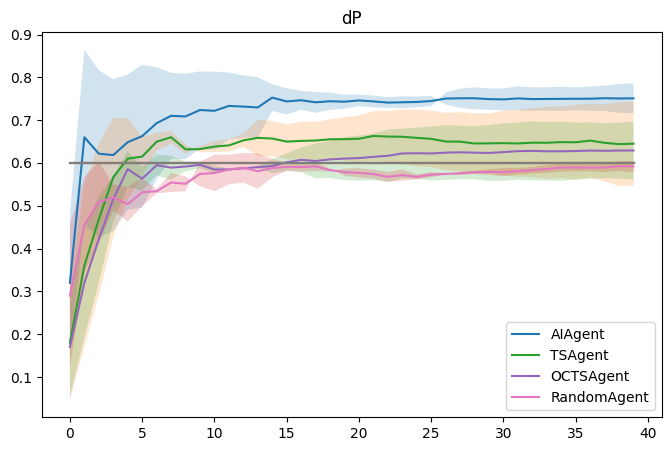

In [19]:
# Parameters for the environment
PARAMS = [0.2, 0.8, 0.3, 0.7, 0.5, 0.5, 0.5]
#PARAMS = [0.5, 0.5, 0.5, 0.5,0.5, 0.5, 0.9]
#PARAMS = [0.8, 0.2, 0.7, 0.3, 0.5, 0.5, 0.9]
#PARAMS = [0.2,0.8,0.3,0.7]

# Possible actions
#ACTIONS = [("X", 0), ("X", 1), ("Z", 0), ("Z", 1)]
ACTIONS = [("X",0),("X",1)] # for BernoulliBandit env

# Environment class to be used
#ENV = BernoulliCausalBandit
ENV = BernoulliBandit

# Calling the function to plot comparison of causal estimates
plot_comparison_causal_estimates(ACTIONS, ENV, PARAMS)

In [20]:
# Parameters for the environment
PARAMS = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.9]

# Possible actions
ACTIONS = [("X", 0), ("X", 1)]
ACTIONS = [("X",0),("X",1), ("Z", 0), ("Z", 1)]


# Environment class to be used
ENV = BernoulliBandit
#ENV = BernoulliCausalBandit

# Calling the function to get comparison of causal estimates
df = get_comparison_causal_estimates(ACTIONS, ENV, PARAMS)


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 930.49it/s]


In [21]:

# Convert lists in 'Dp_means' column to separate columns for easier analysis
means_df = df['Dp_means'].apply(pd.Series)
means_df.columns = ['mean_{}'.format(i) for i in range(means_df.shape[1])]

# Now perform pairwise Mann-Whitney U tests
# Initialize a dictionary to store p-values
p_values = {}

# Perform the test on each pair of agents
for i in range(len(df) - 1):
    for j in range(i + 1, len(df)):
        agent_i = df['Agent'][i]
        agent_j = df['Agent'][j]
        stat, p_value = mannwhitneyu(means_df.iloc[i], means_df.iloc[j], alternative='two-sided')
        p_values[f'{agent_i} vs {agent_j}'] = p_value

p_values


{'AIAgent vs TSAgent': 0.9577923943680281,
 'AIAgent vs OCTSAgent': 1.4350853063936676e-14,
 'AIAgent vs Agent': 2.9867932631769597e-06,
 'TSAgent vs OCTSAgent': 2.4237616717109487e-14,
 'TSAgent vs Agent': 1.3354837378164618e-05,
 'OCTSAgent vs Agent': 1.547155662456581e-14}

In [22]:

# Let's use the means DataFrame from the previous code snippet for ANOVA test

# Extract means for each agent from the mock data (assuming the same number of means per agent)
means_AlAgent = means_df.iloc[0].dropna()
means_TSAgent = means_df.iloc[1].dropna()
means_OCTSAgent = means_df.iloc[2].dropna()
means_RandomAgent = means_df.iloc[3].dropna()

# Perform one-way ANOVA test
f_stat, p_value = f_oneway(means_AlAgent, means_TSAgent, means_OCTSAgent, means_RandomAgent)
f_stat, p_value

(74.08643957339615, 7.641178446356702e-30)

In [23]:

# Flatten the list of means and create a corresponding list of agent labels
flat_means = means_AlAgent.tolist() + means_TSAgent.tolist() + means_OCTSAgent.tolist() + means_RandomAgent.tolist()
agents_labels = ['AlAgent']*len(means_AlAgent) + ['TSAgent']*len(means_TSAgent) + \
                ['OCTSAgent']*len(means_OCTSAgent) + ['RandomAgent']*len(means_RandomAgent)

# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=flat_means, groups=agents_labels, alpha=0.05)
tukey_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
AlAgent,OCTSAgent,0.0634,0.0,0.0496,0.0771,True
AlAgent,RandomAgent,-0.0077,0.4678,-0.0215,0.0061,False
AlAgent,TSAgent,0.0081,0.4248,-0.0057,0.0219,False
OCTSAgent,RandomAgent,-0.0711,0.0,-0.0849,-0.0573,True
OCTSAgent,TSAgent,-0.0553,0.0,-0.0691,-0.0415,True
RandomAgent,TSAgent,0.0158,0.0175,0.002,0.0296,True


### Experiment 1 : Bernoulli standard bandit

Utils

In [124]:
def plot_cumulative_regrets_bandit():
    PARAMS = [0.9,0.1,0.6,0.4, 0.5]
    ACTIONS = [("X",0),("X",1)]

    agents = [AIAgent(ACTIONS), TSAgent(ACTIONS), OCTSAgent(ACTIONS), Agent(ACTIONS)]#, AIBanditAgent(ACTIONS, PARAMS[4])]
    envs = [BernoulliBandit(PARAMS) for i in range(len(agents))]
    regrets = [[] for i in range(len(agents))]

    for i in tqdm(range(len(agents))): 
        current_agent = agents[i]
        current_env = envs[i]
        current_regret = regrets[i]

        previous_action = ACTIONS[np.random.randint(2)]

        for t in range(1000):
            observation = current_env.reset()
            for k in range(40):
                if (i==0):
                    action = current_agent.choose_action(observation, previous_action)
                    previous_action = action
                else:
                    action = current_agent.choose_action(observation)
                observation, reward, done, info = current_env.step(action)
            current_regret.append(current_env.regrets)
        
        current_cumul_reg = np.cumsum(current_regret, axis=0)
        _,m = np.shape(current_cumul_reg)
        means = np.asarray([np.mean(current_cumul_reg[j, :]) for j in range(m)])
        stds = np.asarray([np.std(current_cumul_reg[j, :]) for j in range(m)])
        x = np.arange(m)

        plt.plot(x, means)
        plt.fill_between(x, means - stds, means + stds, alpha = 0.2, label='_nolegend_')

    plt.legend(['Active Inference',  'TS', 'OCTS',  'random', 'AI Bandit'])
    plt.title('Cumulative Regrets - Causal Bandit')
    plt.tight_layout()

def generate_cumulative_regrets_causal_bandit():
    N = 5000
    PARAMS = [0.9,0.1,0.6,0.4, 0.5]
    ACTIONS = [("X",0),("X",1)]

    agents = [AIAgent(ACTIONS), TSAgent(ACTIONS), OCTSAgent(ACTIONS), Agent(ACTIONS)]#, AIBanditAgent(ACTIONS, PARAMS[4])]
    envs = [BernoulliBandit(PARAMS) for i in range(len(agents))]
    regrets = [[] for i in range(len(agents))]
    final_regrets = [[] for _ in agents]  # Initialize final_regrets to store the final regret for each agent

    for i in tqdm(range(len(agents))):

        agents = [AIAgent(ACTIONS), TSAgent(ACTIONS), OCTSAgent(ACTIONS), Agent(ACTIONS)]
        current_agent = agents[i]
        current_env = envs[i]
        current_regret = []  # Initialize an empty list to store the regrets for each trial

        previous_action = ACTIONS[np.random.randint(2)]

        for t in range(N):
            observation = current_env.reset()
            for k in range(40):
                if (i == 0):
                    action = current_agent.choose_action(observation, previous_action)
                    previous_action = action
                else:
                    action = current_agent.choose_action(observation)
                observation, reward, done, info = current_env.step(action)
            
            # Append the final cumulative regret after 40 steps
            current_regret.append(np.sum(current_env.regrets))
        
        #current_cumul_regret = np.cumsum(current_regret, axis=0)
        
        # Convert the list of regrets to a numpy array
        current_regret_array = np.array(current_regret)

        # Store the final regrets for the current agent
        final_regrets[i] = current_regret_array

    return np.array(final_regrets)



100%|██████████| 4/4 [00:24<00:00,  6.19s/it]


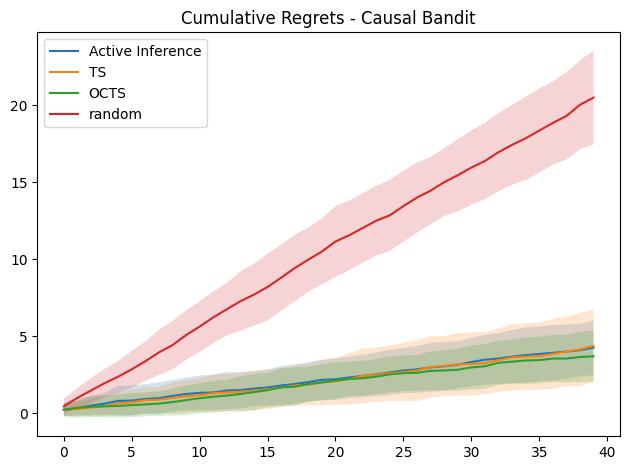

In [125]:
plot_cumulative_regrets_bandit()
final_regrets = generate_cumulative_regrets_causal_bandit()

In [126]:
N = 5000
flattened_final_regrets =final_regrets.reshape(4,N)

# Les données pour chaque algorithme
data_algo1 = flattened_final_regrets[0, :]
data_algo2 = flattened_final_regrets[1, :]
data_algo3 = flattened_final_regrets[2, :]
data_algo4 = flattened_final_regrets[3, :]


# Test de normalité (par exemple, test de Shapiro-Wilk)
_, p1 = stats.shapiro(data_algo1)
_, p2 = stats.shapiro(data_algo2)
_, p3 = stats.shapiro(data_algo3)
_, p4 = stats.shapiro(data_algo4)

# Si toutes les données sont normalement distribuées (p > 0.05)
if p1 > 0.05 and p2 > 0.05 and p3 > 0.05 and p4 > 0.05:
    # Test ANOVA
    f_value, p_value = stats.f_oneway(data_algo1, data_algo2, data_algo3, data_algo4)
    if p_value < 0.05:
        # Test post-hoc
        all_data = np.concatenate([data_algo1, data_algo2, data_algo3, data_algo4])
        groups = ['algo1']*N + ['algo2']*N + ['algo3']*N + ['algo4']*N
        tukey_result = pairwise_tukeyhsd(all_data, groups, alpha=0.05)
        print(tukey_result.summary())
else:
    # Utiliser un test non-paramétrique si les données ne sont pas normales
    # Par exemple, le test de Kruskal-Wallis suivi de tests post-hoc appropriés
    #Test de Kruskal-Wallis
    kruskal_stat, p_value = stats.kruskal(data_algo1, data_algo2, data_algo3, data_algo4)

    print("Kruskal-Wallis H-statistic:", kruskal_stat)
    print("P-value:", p_value)

Kruskal-Wallis H-statistic: 11374.00752924121
P-value: 0.0


In [127]:
# Créer une liste pour les étiquettes des groupes
groups = ['Algo1', 'Algo2', 'Algo3', 'Algo4']

# Étendre cette liste pour qu'elle corresponde au nombre d'observations
group_labels = np.repeat(groups, flattened_final_regrets.shape[1])

# Aplatir les données pour qu'elles correspondent aux étiquettes des groupes
flat_data = flattened_final_regrets.flatten()

# Créer le DataFrame
df = pd.DataFrame({'Group': group_labels, 'Regret': flat_data})

# Vérifier les premières lignes du DataFrame
print(df.head())


   Group  Regret
0  Algo1       4
1  Algo1       6
2  Algo1       4
3  Algo1       6
4  Algo1       7


In [128]:

# Nous supposons que vos données sont dans un DataFrame appelé df,
# avec une colonne 'Group' indiquant l'appartenance à l'algorithme et
# une colonne 'Regret' contenant les regrets cumulatifs.

# Effectuer le test de Dunn (par exemple, après un Kruskal-Wallis significatif)
posthoc_result = sp.posthoc_dunn(df, val_col='Regret', group_col='Group', p_adjust='bonferroni')

# Afficher les résultats
print(posthoc_result)


       Algo1     Algo2     Algo3  Algo4
Algo1    1.0  1.000000  1.000000    0.0
Algo2    1.0  1.000000  0.977585    0.0
Algo3    1.0  0.977585  1.000000    0.0
Algo4    0.0  0.000000  0.000000    1.0


In [129]:
# Définir les paires d'algorithmes à comparer
pairs = [(data_algo1, data_algo2), (data_algo1, data_algo3), (data_algo1, data_algo4),
         (data_algo2, data_algo3), (data_algo2, data_algo4), (data_algo3, data_algo4)]

# Correction de Bonferroni
alpha = 0.05 / len(pairs)

# Effectuer le test de Mann-Whitney pour chaque paire
for i, (group1, group2) in enumerate(pairs):
    stat, p = stats.mannwhitneyu(group1, group2)
    if p < alpha:
        print(f"Différence significative entre le groupe {i+1} (p={p})")


Différence significative entre le groupe 3 (p=0.0)
Différence significative entre le groupe 5 (p=0.0)
Différence significative entre le groupe 6 (p=0.0)


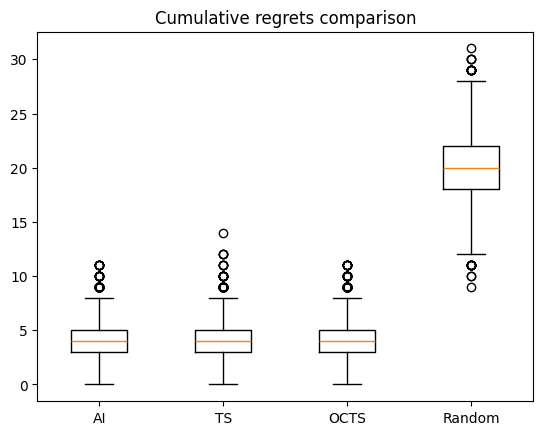

In [130]:
# Créer un boxplot
data_to_plot = [data_algo1, data_algo2, data_algo3, data_algo4]
plt.boxplot(data_to_plot)

plt.title('Cumulative regrets comparison')
#plt.ylabel('Cumulative regret')
#plt.xlabel('Agents')
plt.xticks([1, 2, 3, 4], ['AI', 'TS', 'OCTS', 'Random'])

# Afficher le plot
plt.show()


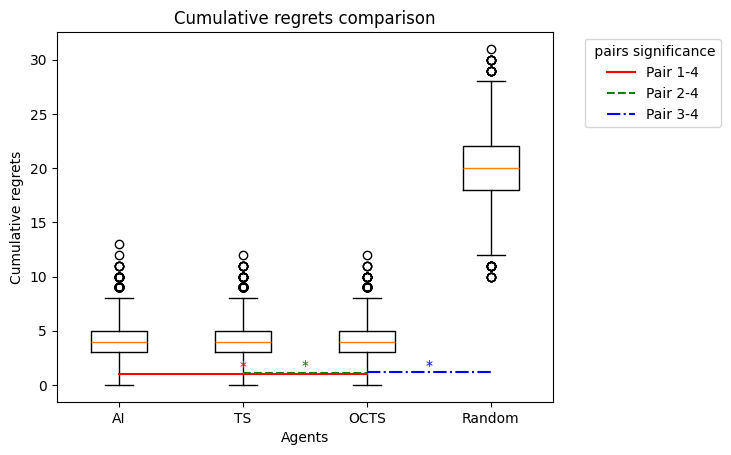

In [31]:

# Créer un boxplot
data_to_plot = [data_algo1, data_algo2, data_algo3, data_algo4]
plt.boxplot(data_to_plot)

plt.title('Cumulative regrets comparison')
plt.ylabel('Cumulative regrets')
plt.xlabel('Agents')
plt.xticks([1, 2, 3, 4], ['AI', 'TS', 'OCTS', 'Random'])

# Ajouter des annotations
significant_pairs = [(1, 3), (2, 3), (3, 4)]  # Exemple: Groupes 1 et 3, 2 et 3, 3 et 4 diffèrent
max_y = max(max(data) for data in data_to_plot) * 1.1  # Calculez une valeur de y pour dessiner les lignes
# Les labels pour chaque paire
pair_labels = ['Pair 1-4', 'Pair 2-4', 'Pair 3-4']

colors = ['red', 'green', 'blue', 'purple']
linestyles = ['-', '--', '-.', ':']
# Hauteur de base pour dessiner les lignes de signification
y_height = 1.05
line_objects = []

for idx, pair in enumerate(significant_pairs):
  # Choisissez une couleur et un style basés sur l'index
    color = colors[idx % len(colors)]
    linestyle = linestyles[idx % len(linestyles)]
    
    # Dessiner une ligne entre les paires
    line, = plt.plot(pair, [y_height, y_height], color=color, lw=1.5, linestyle=linestyle, label=pair_labels[idx])
    line_objects.append(line)

    # Ajouter une étoile pour la signification
    star_x = sum(pair) / 2
    plt.text(star_x, y_height, '*', ha='center', va='bottom', color=color)
    
    # Augmentez la hauteur pour la prochaine ligne pour éviter de chevaucher
    y_height += 0.05

# ... (le reste de votre code pour préparer le boxplot)

# Filtrer les objets de ligne pour exclure ceux avec un label qui commence par '_'
filtered_line_objects = [obj for obj in line_objects if not obj.get_label().startswith('_')]

# Ajouter la légende avec les objets filtrés
plt.legend(handles=filtered_line_objects, bbox_to_anchor=(1.05, 1), loc='upper left', title=" pairs significance")

# ... (le reste de votre code pour afficher le graphique)

plt.show()


In [32]:
def get_hist_rewards_actions(agent, env):

    observation = env.reset()

    hist_observations = []
    hist_rewards = []
    hist_actions = []

    previous_action = agent.actions[np.random.randint(2)]

    for t in range(40):

        if ('AIAgent' in str(agent)):
            action = agent.choose_action(observation, previous_action)
            previous_action = action
        else:
            action = agent.choose_action(observation)
        observation, reward, done, info = env.step(action)

        hist_rewards.append(reward)
        hist_actions.append(action)
    

    return hist_rewards, hist_actions

In [33]:
PARAMS = [0.2,0.8,0.2,0.8, 1.0]
ACTIONS = [("X",0),("X",1)]

env = BernoulliBandit(PARAMS)

randagent = Agent(ACTIONS)
aiagent = AIAgent(ACTIONS)
aibanditgent = AIBanditAgent(ACTIONS, param = PARAMS[4])
tsagent = TSAgent(ACTIONS)
octsagent = OCTSAgent(ACTIONS)

hist_randag_rewards, hist_randag_actions = get_hist_rewards_actions(randagent, env)
hist_tsag_rewards, hist_tsag_actions = get_hist_rewards_actions(tsagent, env)
hist_octsag_rewards, hist_octsag_actions = get_hist_rewards_actions(octsagent, env)
hist_aiag_rewards, hist_aiag_actions = get_hist_rewards_actions(aiagent, env)


#### Random Agent

100%|██████████| 1000/1000 [00:01<00:00, 769.64it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:01<00:00, 781.72it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:01<00:00, 787.12it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:01<00:00, 790.70it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


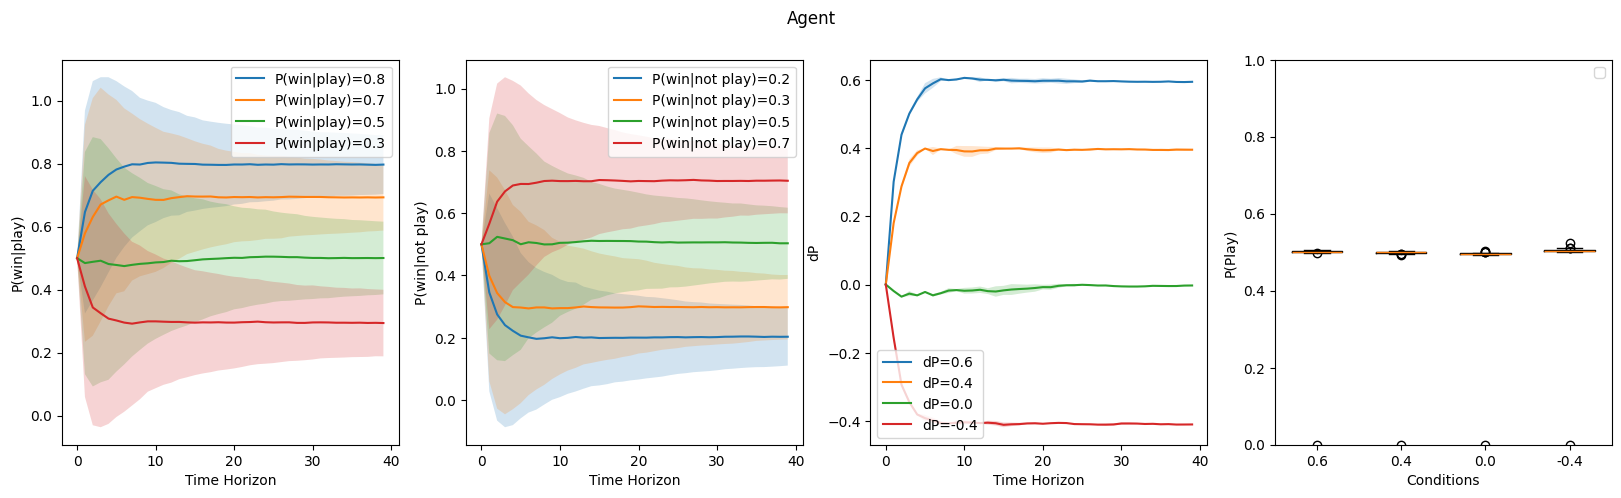

In [104]:
ACTIONS = [("X",0),("X",1)]
plot_prob(Agent, BernoulliBandit, ACTIONS,  switch=0, reset_agent=True)

#### TSAgent

100%|██████████| 1000/1000 [00:02<00:00, 412.93it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:02<00:00, 410.71it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:02<00:00, 408.80it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:02<00:00, 414.77it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


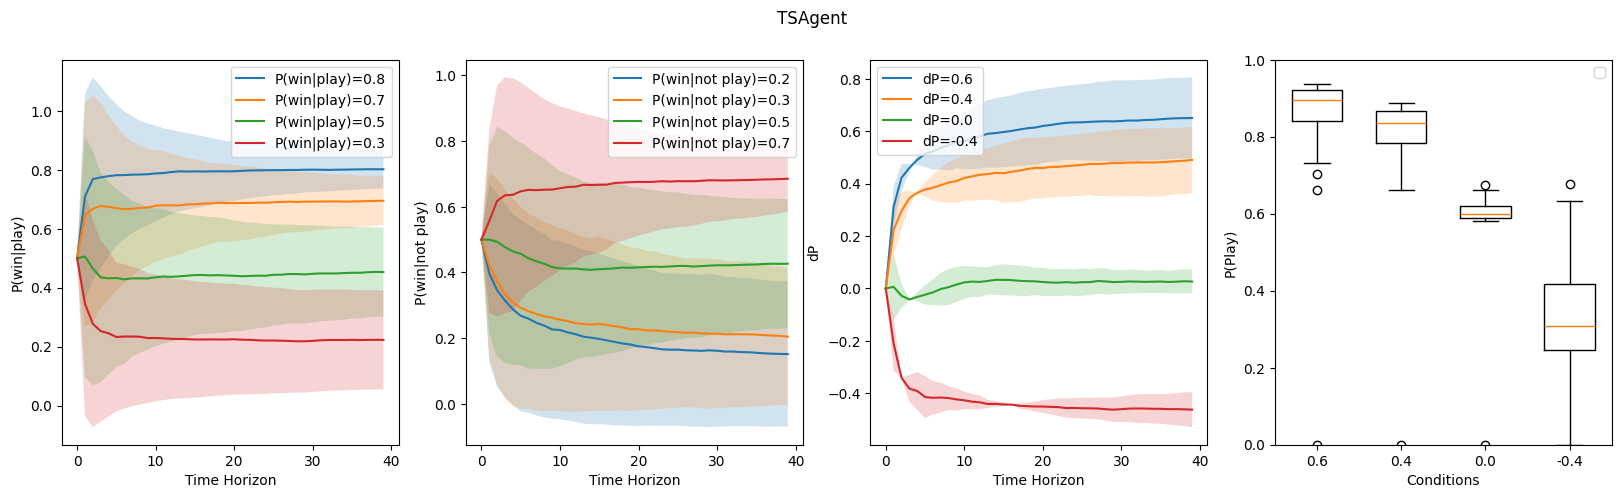

In [105]:
ACTIONS = [("X",0),("X",1)]
plot_prob(TSAgent, BernoulliBandit, ACTIONS,  switch=0.8, reset_agent=True)

#### OCTSAgent

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:02<00:00, 414.15it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:02<00:00, 386.66it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:02<00:00, 412.62it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:02<00:00, 418.61it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


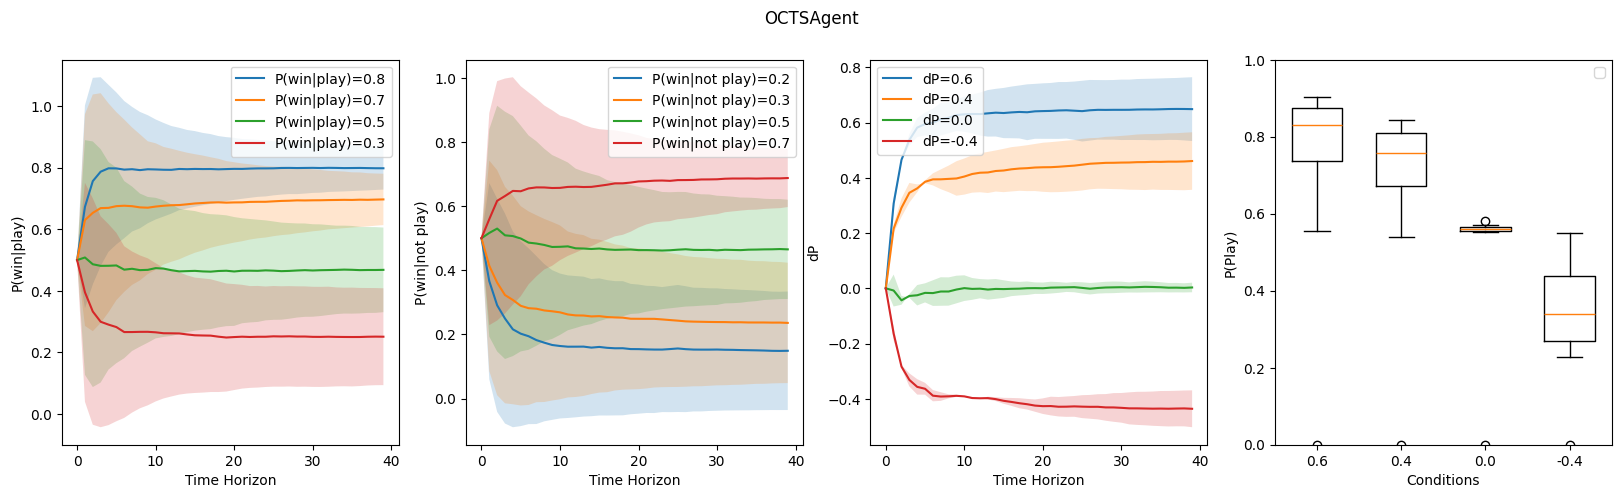

In [106]:
ACTIONS = [("X",0),("X",1)]
plot_prob(OCTSAgent, BernoulliBandit, ACTIONS,  switch=0.8, reset_agent=True)

#### AIAgent

100%|██████████| 1000/1000 [00:01<00:00, 709.04it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:01<00:00, 724.03it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:01<00:00, 704.71it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:01<00:00, 716.49it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


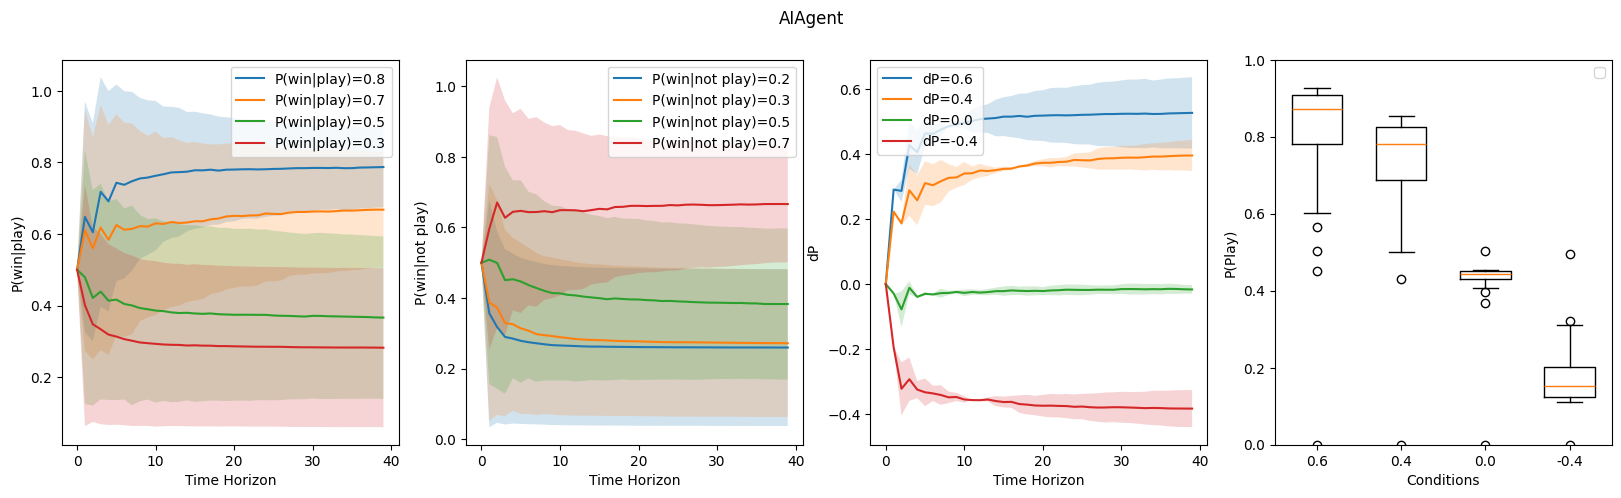

In [107]:
ACTIONS = [("X",0),("X",1)]
plot_prob(AIAgent, BernoulliBandit, ACTIONS,  switch=0.8, reset_agent=True)

### Experiment 2 : Bernoulli Causal Bandit

In [88]:
def plot_cumulative_regrets_causal_bandit():
    PARAMS = [0.9,0.1,0.6,0.4, 0.5]
    ACTIONS = [("X",0),("X",1)]

    agents = [AIAgent(ACTIONS), TSAgent(ACTIONS), OCTSAgent(ACTIONS), Agent(ACTIONS)]#, AIBanditAgent(ACTIONS, PARAMS[4])]
    envs = [BernoulliCausalBandit(PARAMS) for i in range(len(agents))]
    regrets = [[] for i in range(len(agents))]

    for i in tqdm(range(len(agents))): 
        current_agent = agents[i]
        current_env = envs[i]
        current_regret = regrets[i]

        previous_action = ACTIONS[np.random.randint(2)]

        for t in range(10000):
            observation = current_env.reset()
            for k in range(40):
                if (i==0):
                    action = current_agent.choose_action(observation, previous_action)
                    previous_action = action
                else:
                    action = current_agent.choose_action(observation)
                observation, reward, done, info = current_env.step(action)
            current_regret.append(current_env.regrets)
        
        current_cumul_reg = np.cumsum(current_regret, axis=0)
        _,m = np.shape(current_cumul_reg)
        means = np.asarray([np.mean(current_cumul_reg[j, :]) for j in range(m)])
        stds = np.asarray([np.std(current_cumul_reg[j, :]) for j in range(m)])
        x = np.arange(m)

        plt.plot(x, means)
        plt.fill_between(x, means - stds, means + stds, alpha = 0.2, label='_nolegend_')

    plt.legend(['Active Inference',  'TS', 'OCTS',  'random', 'AI Bandit'])
    plt.title('Cumulative Regrets - Bernoulli Causal Bandit')
    plt.tight_layout()


100%|██████████| 4/4 [01:31<00:00, 22.93s/it]


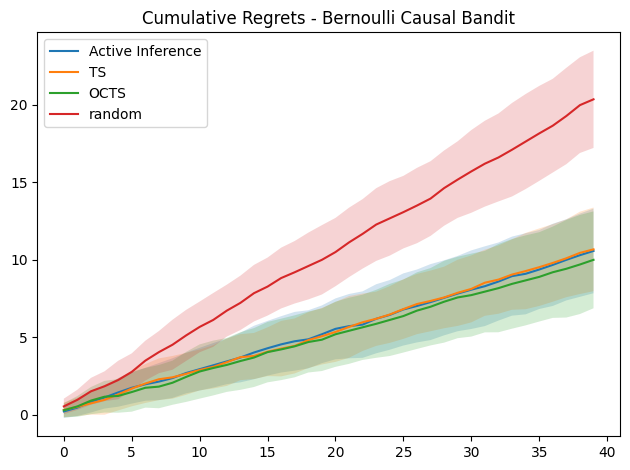

In [89]:
plot_cumulative_regrets_causal_bandit()

Utils : Calcul de significance

In [40]:
def get_prob(agent_name: str, env_name: str, actions, switch: float=0.0, reset_agent: bool=True, change: bool = False):

    
    index = ["0.6", "0.4", "0.0", "-0.4"]

    data = []

    max_reward = 1

    with warnings.catch_warnings():

        warnings.simplefilter("ignore")   

        for k in range(4):
            list_params = [[0.8, 0.2, 0.7, 0.3, switch],
                        [0.7, 0.3, 0.7, 0.3, switch],
                        [0.5, 0.5, 0.5, 0.5, switch],
                        [0.3, 0.7, 0.3, 0.7, switch]
                        ]
            
            if str(env_name).find('BernoulliCausalBandit') > 0:
                list_params = [[0.8, 0.2, 0.7, 0.3, 0.5, 0.5, switch],
                        [0.7, 0.3, 0.7, 0.3, 0.5, 0.5, switch],
                        [0.5, 0.5, 0.5, 0.5,0.5, 0.5, switch],
                        [0.3, 0.7, 0.3, 0.7,0.5, 0.5, switch]
                        ]
                        
            PARAMS = list_params[k]
            env = env_name(PARAMS)
            observation = {'X': 0, 'Y': 0, 'Z': 0}
        
            if not(reset_agent):
                agent = agent_name(actions)

            list_pwp = []
            list_pwnp = []
            list_play = []

            for i in tqdm(range(100)):

                hist_observations = []
                hist_randag_rewards = []
                hist_randag_actions = []
                observation = env.reset()

                if reset_agent:
                    agent = agent_name(actions)

                previous_action = agent.actions[np.random.randint(2)]

                cumulative_regret = 0
                for t in range(40):
                    if ((t == 20) and change):
                        observation = env.reset()


                    if (str(agent).find("AIAgent") > 0 ):
                        action = agent.choose_action(observation, previous_action)
                        previous_action = action
                    else:
                        action = agent.choose_action(observation)
                        
                    observation, reward, done, info = env.step(action)
                    hist_randag_rewards.append(reward)
                    hist_randag_actions.append(action)
                    
                    regret = max_reward - reward
                    # Mise à jour du regret cumulatif
                    cumulative_regret += regret

                    #print(reward, action,  reward if action == ("X",1) else np.nan, reward if action == ("X",0) else np.nan)
                    data.append({
                        'Time': t,
                        'P_win_play': reward if action == ("X",1) else np.nan,
                        'P_win_not_play': reward if action == ("X",0) else np.nan,
                        'Action': 'play' if action == ("X",1) else 'not play',
                        'Condition': k,  # Assuming you want to store the probability condition here
                        'Cumulative_Regret': cumulative_regret, 
                        'Agent': agent_name
                    })
                    
                    #if done:
                    #     print("End of this episode.")
                    #    break
                    
            # Create a DataFrame from the collected data
    df = pd.DataFrame(data)

        # Drop NaN values since they cannot be used in ANOVA
    #
    #df.dropna(inplace=True)

    # Now, df can be used for statistical analysis
    return df

def get_cumulative_regrets_causal_bandit():
    PARAMS = [0.9,0.1,0.6,0.4, 0.5]
    ACTIONS = [("X",0),("X",1)]

    agents = [AIAgent(ACTIONS), TSAgent(ACTIONS), OCTSAgent(ACTIONS), Agent(ACTIONS)]#, AIBanditAgent(ACTIONS, PARAMS[4])]
    envs = [BernoulliCausalBandit(PARAMS) for i in range(len(agents))]
    regrets = [[] for i in range(len(agents))]

    for i in tqdm(range(len(agents))): 
        current_agent = agents[i]
        current_env = envs[i]
        current_regret = regrets[i]

        previous_action = ACTIONS[np.random.randint(2)]

        for t in range(1000):
            observation = current_env.reset()
            for k in range(40):
                if (i==0):
                    action = current_agent.choose_action(observation, previous_action)
                    previous_action = action
                else:
                    action = current_agent.choose_action(observation)
                observation, reward, done, info = current_env.step(action)
            current_regret.append(current_env.regrets)
        
        current_cumul_reg = np.cumsum(current_regret, axis=0)
        _,m = np.shape(current_cumul_reg)
        means = np.asarray([np.mean(current_cumul_reg[j, :]) for j in range(m)])
        stds = np.asarray([np.std(current_cumul_reg[j, :]) for j in range(m)])
        x = np.arange(m)

        plt.plot(x, means)
        plt.fill_between(x, means - stds, means + stds, alpha = 0.2, label='_nolegend_')

    plt.legend(['Active Inference',  'TS', 'OCTS',  'random', 'AI Bandit'])
    plt.title('Cumulative Regrets - Causal Bandit')
    plt.tight_layout()


In [131]:
N = 5000
def generate_cumulative_regrets_causal_bandit():
    PARAMS = [0.9,0.1,0.6,0.4, 0.5]
    ACTIONS = [("X",0),("X",1)]

    agents = [AIAgent(ACTIONS), TSAgent(ACTIONS), OCTSAgent(ACTIONS), Agent(ACTIONS)]#, AIBanditAgent(ACTIONS, PARAMS[4])]
    envs = [BernoulliCausalBandit(PARAMS) for i in range(len(agents))]
    regrets = [[] for i in range(len(agents))]
    final_regrets = [[] for _ in agents]  # Initialize final_regrets to store the final regret for each agent

    for i in tqdm(range(len(agents))):

        agents = [AIAgent(ACTIONS), TSAgent(ACTIONS), OCTSAgent(ACTIONS), Agent(ACTIONS)]
        current_agent = agents[i]
        current_env = envs[i]
        current_regret = []  # Initialize an empty list to store the regrets for each trial

        previous_action = ACTIONS[np.random.randint(2)]

        for t in range(N):
            observation = current_env.reset()
            for k in range(40):
                if (i == 0):
                    action = current_agent.choose_action(observation, previous_action)
                    previous_action = action
                else:
                    action = current_agent.choose_action(observation)
                observation, reward, done, info = current_env.step(action)
            
            # Append the final cumulative regret after 40 steps
            current_regret.append(np.sum(current_env.regrets))
        
        #current_cumul_regret = np.cumsum(current_regret, axis=0)
        
        # Convert the list of regrets to a numpy array
        current_regret_array = np.array(current_regret)

        # Store the final regrets for the current agent
        final_regrets[i] = current_regret_array

    return np.array(final_regrets)


In [132]:
final_regrets = generate_cumulative_regrets_causal_bandit()

print(np.shape(final_regrets))


100%|██████████| 4/4 [00:34<00:00,  8.65s/it]

(4, 5000)


In [133]:


flattened_final_regrets =final_regrets.reshape(4,N)

# Les données pour chaque algorithme
data_algo1 = flattened_final_regrets[0, :]
data_algo2 = flattened_final_regrets[1, :]
data_algo3 = flattened_final_regrets[2, :]
data_algo4 = flattened_final_regrets[3, :]


# Test de normalité (par exemple, test de Shapiro-Wilk)
_, p1 = stats.shapiro(data_algo1)
_, p2 = stats.shapiro(data_algo2)
_, p3 = stats.shapiro(data_algo3)
_, p4 = stats.shapiro(data_algo4)

# Si toutes les données sont normalement distribuées (p > 0.05)
if p1 > 0.05 and p2 > 0.05 and p3 > 0.05 and p4 > 0.05:
    # Test ANOVA
    f_value, p_value = stats.f_oneway(data_algo1, data_algo2, data_algo3, data_algo4)
    if p_value < 0.05:
        # Test post-hoc
        all_data = np.concatenate([data_algo1, data_algo2, data_algo3, data_algo4])
        groups = ['algo1']*N + ['algo2']*N + ['algo3']*N + ['algo4']*N
        tukey_result = pairwise_tukeyhsd(all_data, groups, alpha=0.05)
        print(tukey_result.summary())
else:
    # Utiliser un test non-paramétrique si les données ne sont pas normales
    # Par exemple, le test de Kruskal-Wallis suivi de tests post-hoc appropriés
    #Test de Kruskal-Wallis
    kruskal_stat, p_value = stats.kruskal(data_algo1, data_algo2, data_algo3, data_algo4)

    print("Kruskal-Wallis H-statistic:", kruskal_stat)
    print("P-value:", p_value)



Kruskal-Wallis H-statistic: 10901.915267657107
P-value: 0.0


In [134]:
# Définir les paires d'algorithmes à comparer
pairs = [(data_algo1, data_algo2), (data_algo1, data_algo3), (data_algo1, data_algo4),
         (data_algo2, data_algo3), (data_algo2, data_algo4), (data_algo3, data_algo4)]

# Correction de Bonferroni
alpha = 0.05 / len(pairs)

# Effectuer le test de Mann-Whitney pour chaque paire
for i, (group1, group2) in enumerate(pairs):
    stat, p = stats.mannwhitneyu(group1, group2)
    if p < alpha:
        print(f"Différence significative entre le groupe {i+1} (p={p})")


Différence significative entre le groupe 3 (p=0.0)
Différence significative entre le groupe 5 (p=0.0)
Différence significative entre le groupe 6 (p=0.0)


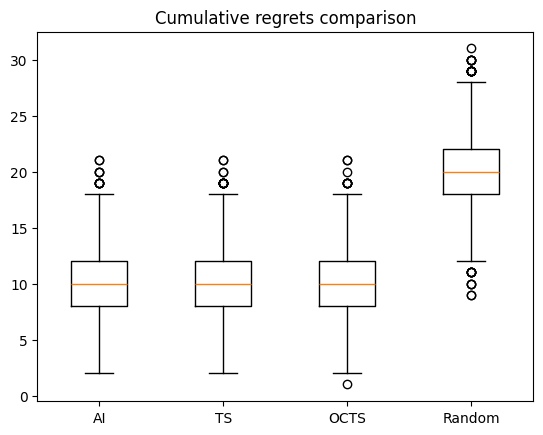

In [135]:
# Créer un boxplot
data_to_plot = [data_algo1, data_algo2, data_algo3, data_algo4]
plt.boxplot(data_to_plot)

plt.title('Cumulative regrets comparison')
#plt.ylabel('Cumulative regrets')
#plt.xlabel('Agents')
plt.xticks([1, 2, 3, 4], ['AI', 'TS', 'OCTS', 'Random'])

# Afficher le plot
plt.show()


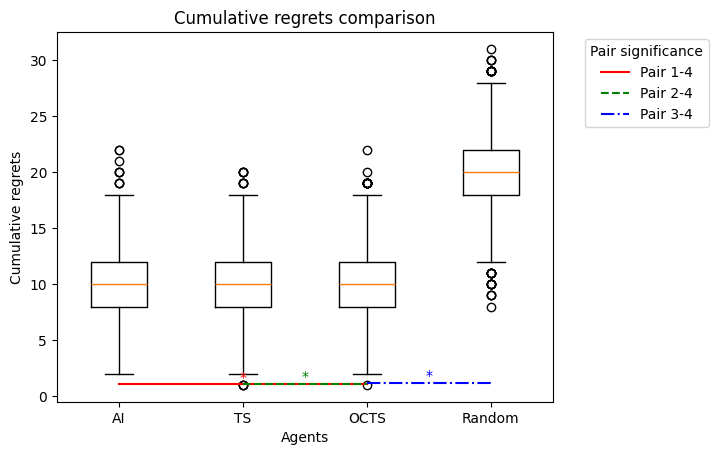

In [46]:


# Créer un boxplot
data_to_plot = [data_algo1, data_algo2, data_algo3, data_algo4]
plt.boxplot(data_to_plot)

plt.title('Cumulative regrets comparison')
plt.ylabel('Cumulative regrets')
plt.xlabel('Agents')
plt.xticks([1, 2, 3, 4], ['AI', 'TS', 'OCTS', 'Random'])

# Ajouter des annotations
significant_pairs = [(1, 3), (2, 3), (3, 4)]  # Exemple: Groupes 1 et 3, 2 et 3, 3 et 4 diffèrent
max_y = max(max(data) for data in data_to_plot) * 1.1  # Calculez une valeur de y pour dessiner les lignes
# Les labels pour chaque paire
pair_labels = ['Pair 1-4', 'Pair 2-4', 'Pair 3-4']

colors = ['red', 'green', 'blue', 'purple']
linestyles = ['-', '--', '-.', ':']
# Hauteur de base pour dessiner les lignes de signification
y_height = 1.05
line_objects = []

for idx, pair in enumerate(significant_pairs):
  # Choisissez une couleur et un style basés sur l'index
    color = colors[idx % len(colors)]
    linestyle = linestyles[idx % len(linestyles)]
    
    # Dessiner une ligne entre les paires
    line, = plt.plot(pair, [y_height, y_height], color=color, lw=1.5, linestyle=linestyle, label=pair_labels[idx])
    line_objects.append(line)

    # Ajouter une étoile pour la signification
    star_x = sum(pair) / 2
    plt.text(star_x, y_height, '*', ha='center', va='bottom', color=color)
    
    # Augmentez la hauteur pour la prochaine ligne pour éviter de chevaucher
    y_height += 0.05

# ... (le reste de votre code pour préparer le boxplot)

# Filtrer les objets de ligne pour exclure ceux avec un label qui commence par '_'
filtered_line_objects = [obj for obj in line_objects if not obj.get_label().startswith('_')]

# Ajouter la légende avec les objets filtrés
plt.legend(handles=filtered_line_objects, bbox_to_anchor=(1.05, 1), loc='upper left', title="Pair significance")

# ... (le reste de votre code pour afficher le graphique)

plt.show()


In [47]:

# Calcul des médianes
median_algo1 = np.median(data_algo1)
median_algo2 = np.median(data_algo2)
median_algo3 = np.median(data_algo3)
median_algo4 = np.median(data_algo4)

# Création d'un DataFrame pour afficher les résultats dans un tableau
df_medians = pd.DataFrame({
    'Algorithme': ['Algo1', 'Algo2', 'Algo3', 'Algo4'],
    'Médiane': [median_algo1, median_algo2, median_algo3, median_algo4]
})

# Affichage du tableau
print(df_medians)


  Algorithme  Médiane
0      Algo1     10.0
1      Algo2     10.0
2      Algo3     10.0
3      Algo4     20.0


In [48]:
randag_pwp, randag_pwnp, _ = compute_probs(hist_randag_rewards, hist_randag_actions)
tsag_pwp, tsag_pwnp, _ = compute_probs(hist_tsag_rewards, hist_tsag_actions)
octsag_pwp, octsag_pwnp, _ = compute_probs(hist_octsag_rewards, hist_octsag_actions)
aiag_pwp, aiag_pwnp, _ = compute_probs(hist_aiag_rewards, hist_aiag_actions)

Random agent

100%|██████████| 1000/1000 [00:01<00:00, 527.49it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:01<00:00, 545.09it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:01<00:00, 551.66it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:01<00:00, 554.31it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


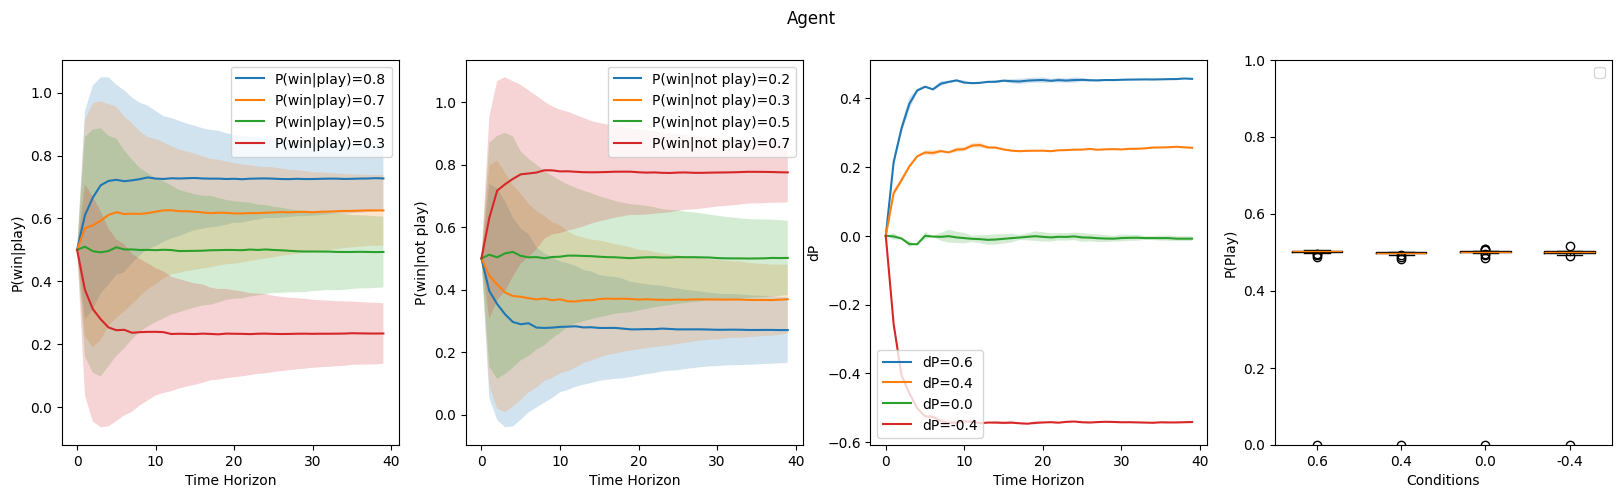

In [108]:
ACTIONS = [("X",0),("X",1)]
plot_prob(Agent, BernoulliCausalBandit, ACTIONS,  switch=0.8, reset_agent=True)

TS Agent

100%|██████████| 1000/1000 [00:03<00:00, 325.77it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:03<00:00, 327.99it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:03<00:00, 316.06it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:03<00:00, 326.72it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


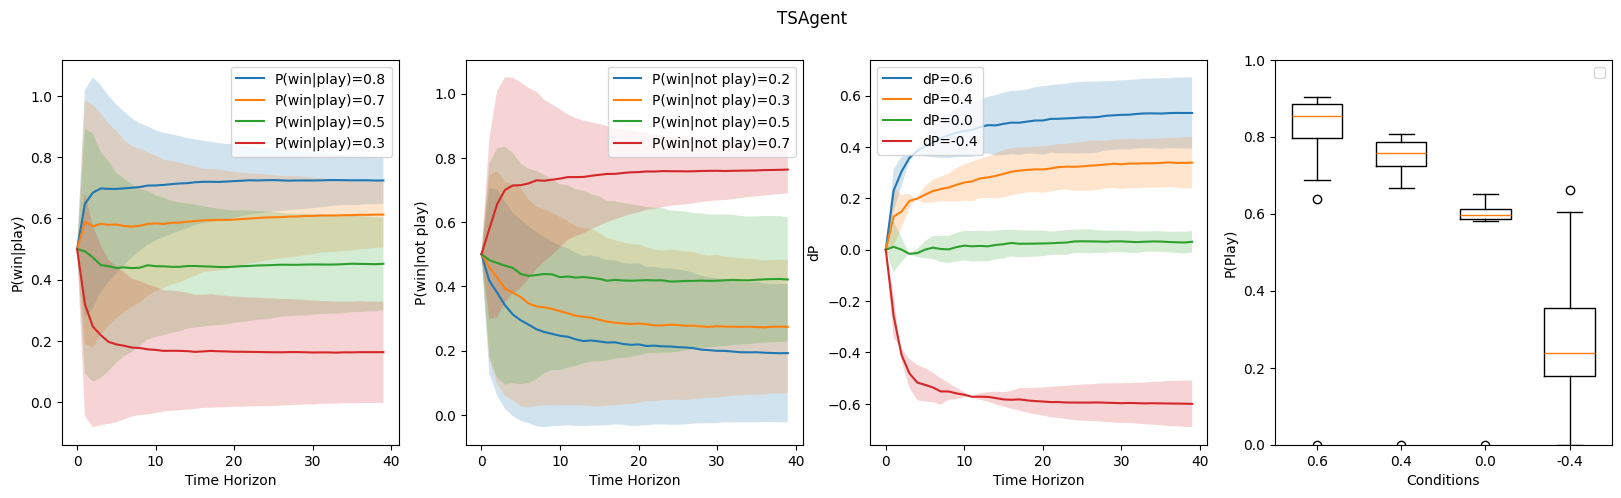

In [109]:
plot_prob(TSAgent, BernoulliCausalBandit, actions= ACTIONS,  reset_agent=True, switch=0.8)

In [110]:
df = get_prob(OCTSAgent, BernoulliCausalBandit, actions= ACTIONS,  reset_agent=True, switch=0.9)

100%|██████████| 100/100 [00:00<00:00, 396.27it/s]


In [52]:


# 'action' is a categorical variable with levels 'play' and 'not play'
# 'condition' is a categorical variable with levels 0.8, 0.7, 0.5, 0.03
# 'cumulative_regret' is a continuous variable representing the regret at the end of the 40th trial

# Fit the two-way ANOVA model
model = ols('Cumulative_Regret ~ C(Action) * C(Condition)', data=df).fit()

# Perform two-way ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)

# Print the results
print(anova_results)


                               sum_sq       df           F         PR(>F)
C(Action)                  122.319241      1.0    4.776963   2.885740e-02
C(Condition)             21916.634573      3.0  285.305204  1.998732e-180
C(Action):C(Condition)    8125.147611      3.0  105.771116   8.332321e-68
Residual                409492.261648  15992.0         NaN            NaN


In [53]:


# Convert the list of dictionaries to a DataFrame

# Filter the DataFrame to get the relevant subsets for the two conditions
# Let's assume 'Condition' is stored as a numeric value, and we need to compare condition 0.7 and 0.8

condition_07 = df[(df['Condition'] == 0)]['P_win_play'].dropna()
condition_08 = df[(df['Condition'] == 1)]['P_win_play'].dropna()

# Perform the Mann-Whitney U test
u_stat, p_value = mannwhitneyu(condition_07, condition_08, alternative='two-sided')

# Output the test statistic and p-value
print(f'Mann-Whitney U statistic: {u_stat}')
print(f'p-value: {p_value}')


Mann-Whitney U statistic: 6385486.0
p-value: 1.535356121452795e-07


OCTS agent

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:02<00:00, 342.85it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:02<00:00, 343.62it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:02<00:00, 340.50it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:02<00:00, 341.88it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


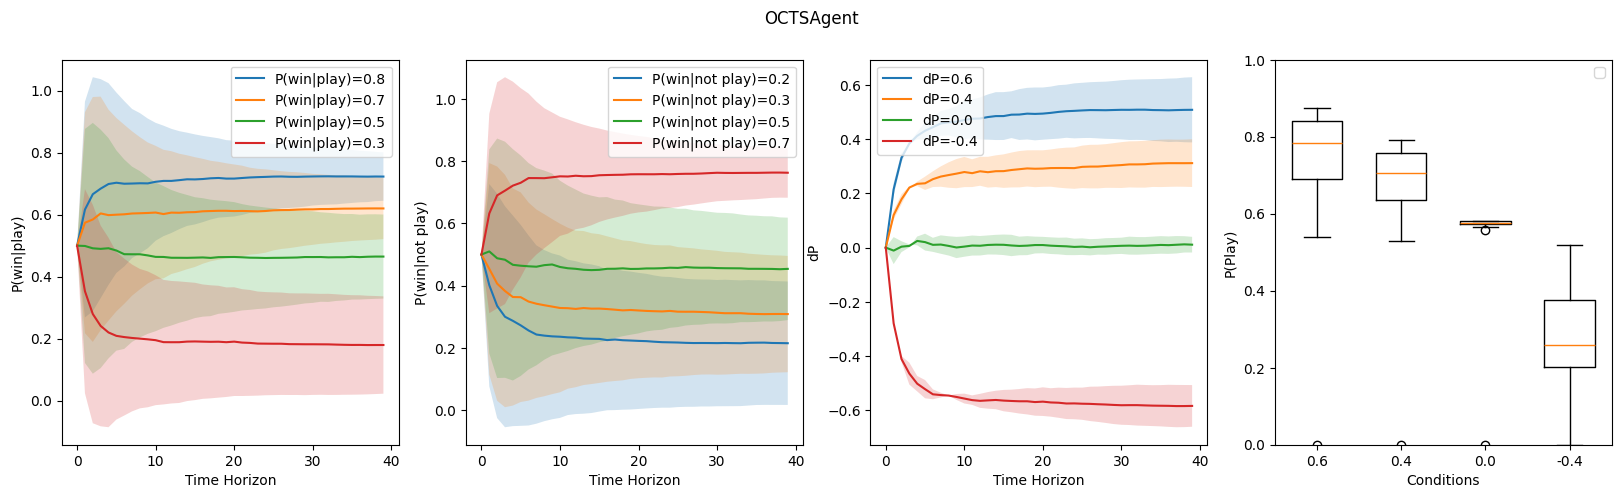

In [111]:
plot_prob(OCTSAgent, BernoulliCausalBandit, ACTIONS,  reset_agent=True, switch=0.8, change=True)

Active Inference agent

100%|██████████| 1000/1000 [00:01<00:00, 509.03it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:01<00:00, 515.14it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:01<00:00, 526.75it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:01<00:00, 522.15it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


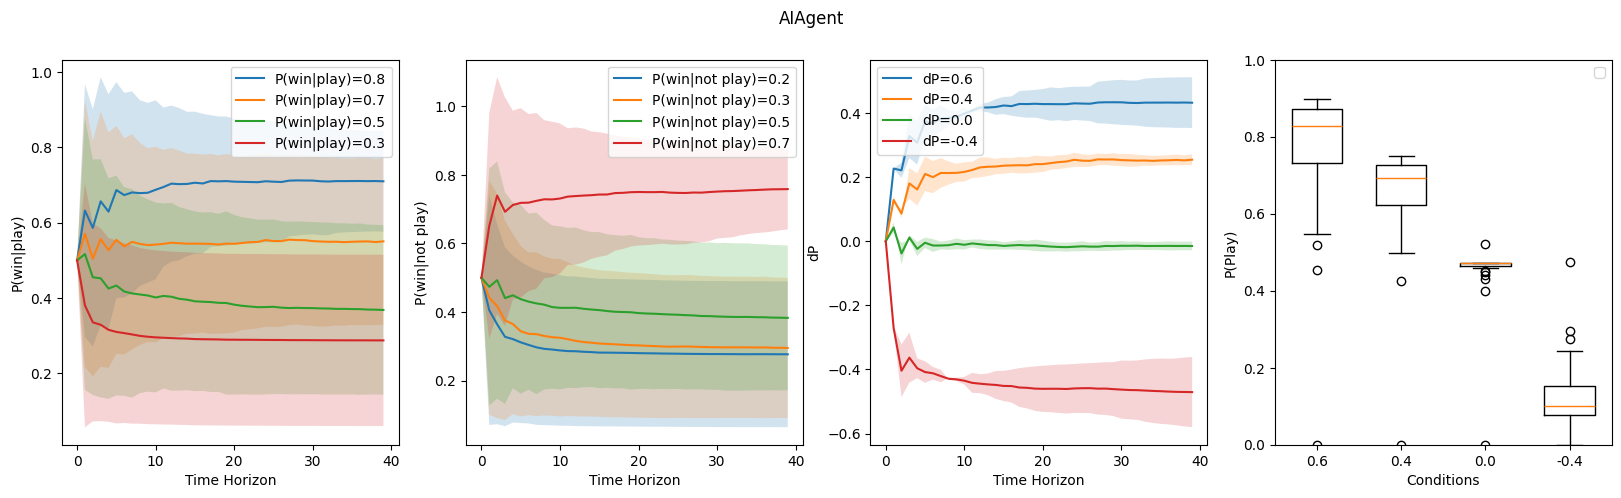

In [112]:
plot_prob(AIAgent, BernoulliCausalBandit, ACTIONS, reset_agent=True, switch=0.8)
#agent = AIBanditAgent(ACTIONS, PARAMS[4])

Anova test

In [56]:
df = get_prob(OCTSAgent, BernoulliCausalBandit, actions= ACTIONS,  reset_agent=True, switch=0.9)

100%|██████████| 100/100 [00:00<00:00, 315.54it/s]


In [57]:
df_grouped = df.groupby([ 'Action']).agg({'P_win_play': 'std', 'P_win_not_play': 'std'}).reset_index()
df_grouped

,Action,P_win_play,P_win_not_play
0,not play,NaN,0.495232
1,play,0.479645,NaN


In [58]:

# Assuming you have a pandas DataFrame 'df' structured as described previously

# Calculate standard deviations for each action type
std_win_play = df[df['Action'] == 'play']['P_win_play'].std()
std_win_not_play = df[df['Action'] == 'not play']['P_win_not_play'].std()

# Print the standard deviations just to see the values
print(f"Standard Deviation for P(win|play): {std_win_play}")
print(f"Standard Deviation for P(win|not play): {std_win_not_play}")

# Perform Levene's test
stat, p = levene(df[df['Action'] == 'play']['P_win_play'].dropna(),
                 df[df['Action'] == 'not play']['P_win_not_play'].dropna())

print('Levene’s test statistic:', stat)
print('p-value:', p)


Standard Deviation for P(win|play): 0.47964494046678335
Standard Deviation for P(win|not play): 0.495231651364164
Levene’s test statistic: 82.92738309071457
p-value: 9.499012652794111e-20


#### p(play) over time

In [59]:
def compute_probs_conf(arg_rewards, arg_actions):

    with warnings.catch_warnings():

        warnings.simplefilter("ignore")

        actions = [action for action in arg_actions if action[0] == "X"]
        rewards = [reward for (action, reward) in zip(arg_actions, arg_rewards) if action[0] == "X"]

        # compute probability to win when the agent's play
        win_play = [((action[1] and reward)) for (action, reward) in zip(actions, rewards)]
        num_win_play = [np.sum(win_play[:i]) for i in range(len(win_play))]
        num_play = [np.sum([action[1] for action in actions[:i]]) for i in range(len(actions))]
        p_win_play = [win_play_t/play_total_t for (win_play_t, play_total_t) in zip(num_win_play, num_play)]

        # compute the probability to win when the agent doesn't play
        win_no_play = [int(not(action[1]) and reward) for (action, reward) in zip(actions, rewards)]
        num_win_no_play = [np.sum(win_no_play[:i]) for i in range(len(win_no_play))]
        num_no_play = [np.sum([int(not(action[1])) for action in actions[:i]]) for i in range(len(actions))]
        p_win_no_play = [win_no_play_t/no_play_t for (win_no_play_t, no_play_t) in zip(num_win_no_play, num_no_play)]

        # compute probability of play
        p_win_play = [(0.5 if np.isnan(p) else p) for p in p_win_play]
        p_win_no_play = [(0.5 if np.isnan(p) else p) for p in p_win_no_play]

        p_play = [num_play/i for (i, num_play) in enumerate(num_play)]

        return p_win_play, p_win_no_play, p_play




def compute_p_play(agent_name, reset_agent=True):

    list_params = [[0.2, 0.8, 0.3, 0.7, 0.6, 0.9, 0.1]]
                    #[0.7, 0.3, 0.3, 0.7, switch],
                    #[0.5, 0.5, 0.5, 0.5, switch],
                    #[0.3, 0.7, 0.7, 0.3, switch]]
    p_play_mean = []
    p_play_std = []
    ACTIONS = [("X",0),("X",1), ("Z", 0), ("Z", 1)]

    for k in range(0,len(list_params)):

        with warnings.catch_warnings():

            warnings.simplefilter("ignore") 

            PARAMS = list_params[k]
            env = BernoulliCausalBandit(PARAMS)
            observation = env.reset()  

            if not(reset_agent):
                agent = agent_name(ACTIONS)

            list_play = []

            for i in tqdm(range(1000)):

                hist_observations = []
                hist_ag_rewards = []
                hist_ag_actions = []

                observation = env.reset()

                
                agent = agent_name(ACTIONS)
                    
                previous_action = agent.actions[np.random.randint(len(agent.actions))]

                for k in range(40):
                    action = agent.choose_action(observation, previous_action)
                    observation, reward, done, info = env.step(action) #change here
                    hist_ag_rewards.append(reward)
                    hist_ag_actions.append(action) 
                    previous_action = action
                    
                #for k in range(40):    
                #    action = agent.choose_action(observation)
                #    observation, reward, done, info = env.step(action)
                #    hist_ag_rewards.append(reward)
                #    hist_ag_actions.append(action) 
                #    previous_action = action

                #for t in range(40):
                #    if (t == 20 ):
                #        observation = env.reset()

                #    if  agent.__name__() == "AIAgent":
                #        action = agent.choose_action(observation, previous_action)
                #        previous_action = action
                #    else:
                #        action = agent.choose_action(observation)
                #    observation, reward, done, info = env.step(action)

                #    hist_ag_rewards.append(reward)
                #    hist_ag_actions.append(action) 


                _, _, p_play = compute_probs(hist_ag_rewards, hist_ag_actions)
                
                list_play.append(p_play)

            list_play = np.asarray(list_play)
            _, m = np.shape(list_play)
            p_play_mean.append(np.asarray(([np.nanmean(list_play[:, j]) for j in range(m)])))
            p_play_std.append(np.asarray(([np.nanstd(list_play[:, j]) for j in range(m)])))

    return p_play_mean, p_play_std

In [60]:
p0, ps0 = compute_p_play(Agent)
p1, ps1 = compute_p_play(TSAgent)
p2, ps2 = compute_p_play(OCTSAgent)
p3, ps3 = compute_p_play(AIAgent)

list_p = [p0, p1, p2, p3]
list_ps = [ps0, ps1, ps2, ps3]

LIST_PARAMS = [0.2,0.3, 0.5, 0.7]

#fig, axs = plt.subplots(1, 4, figsize=(20,5))
#m = np.shape(p0)
#x = np.arange(m[1])
#print('x',x)
#print('m',m)
#


  6%|▌         | 56/1000 [00:00<00:01, 555.69it/s]

100%|██████████| 1000/1000 [00:01<00:00, 546.44it/s]


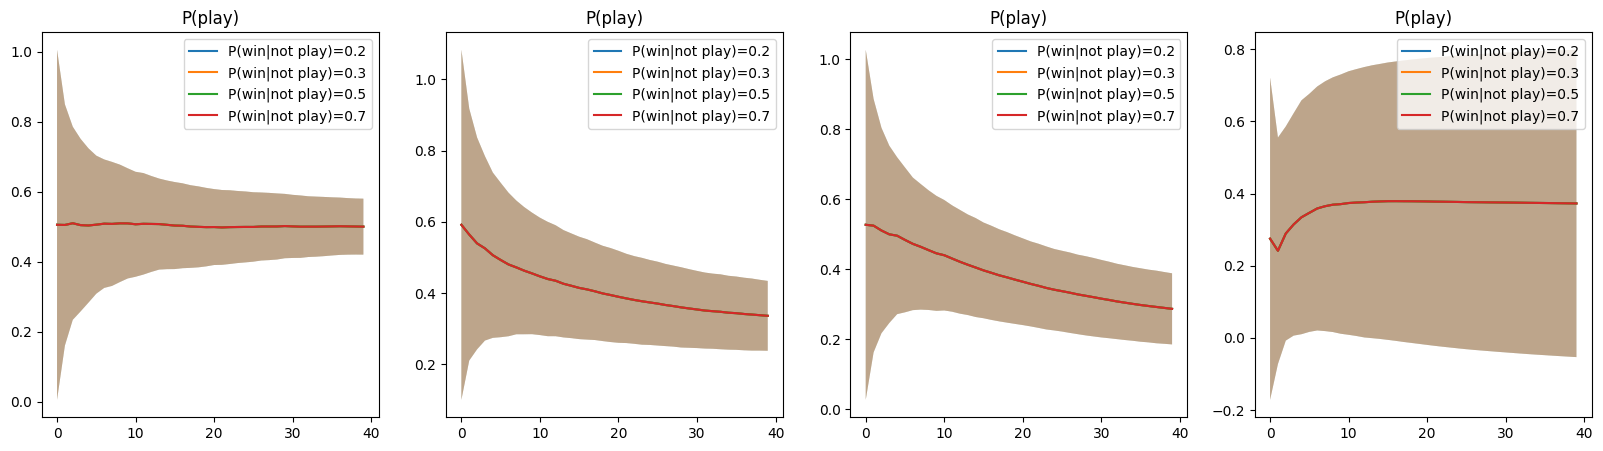

In [61]:

# Supposons que p0, ps0, p1, ps1, etc. sont des listes ou des tableaux NumPy
p_list = [p0, p1, p2, p3]
ps_list = [ps0, ps1, ps2, ps3]

LIST_PARAMS = [0.2, 0.3, 0.5, 0.7]

fig, axs = plt.subplots(1, 4, figsize=(20,5))
x = np.arange(40)  # Assurez-vous que la longueur de x correspond à celle de vos données

for k in range(4):
    for j in range(4):
        # Convertir en tableau NumPy et aplatir si nécessaire
        y_data = np.array(p_list[k]).flatten()  
        y_error = np.array(ps_list[k]).flatten()

        axs[k].plot(x, y_data, label="P(win|not play)={}".format(LIST_PARAMS[j]))
        axs[k].fill_between(x, y_data - y_error, y_data + y_error, alpha=0.2)
        axs[k].set_title('P(play)')
        axs[k].legend()

plt.show()


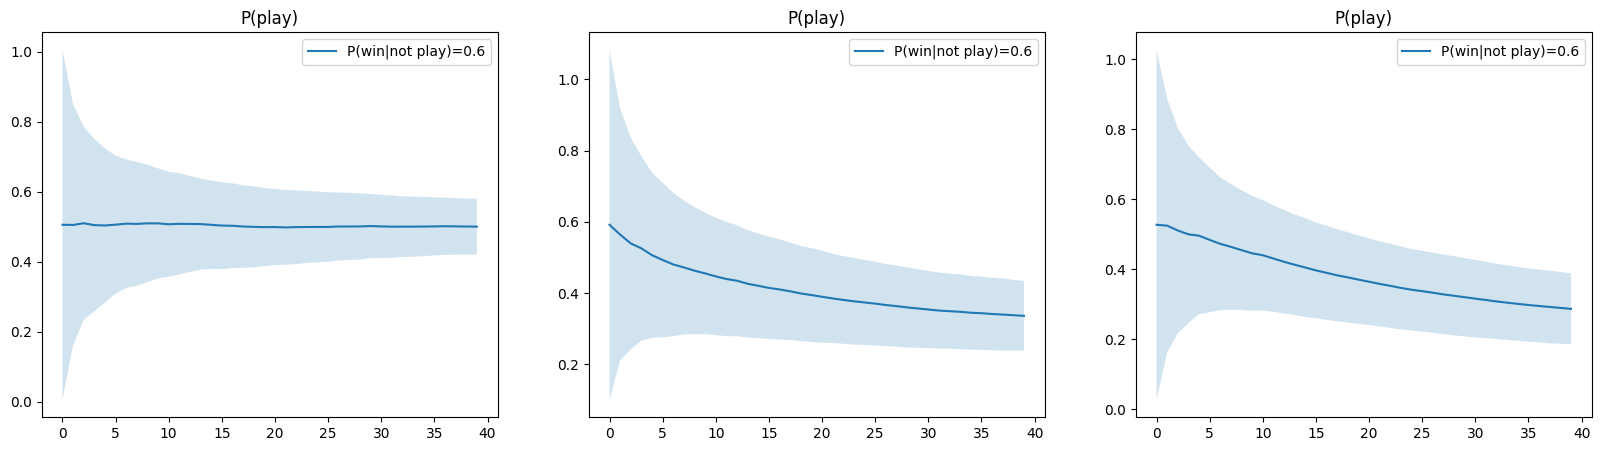

In [62]:
#fig, axs = plt.subplots(1, 4, figsize=(20,5))
#m = np.shape(p0)
#x = np.arange(m[1])
#
#
#for k in range(4):
#    axs[k].plot(x, locals()["p"+str(k)][0], label="P(win|not play)={}".format(0.6))
#    axs[k].fill_between(x, locals()["p"+str(k)][0]-locals()["ps"+str(k)][0], locals()["p"+str(k)][0]+locals()["ps"+str(k)][0], alpha = 0.2)
#    axs[k].set_title('P(play)')
#    axs[k].legend()

Stat Test

In [63]:
dfts = get_prob(TSAgent, BernoulliCausalBandit, actions= ACTIONS,  reset_agent=True, switch=0.9)
dfocts = get_prob(OCTSAgent, BernoulliCausalBandit, actions= ACTIONS,  reset_agent=True, switch=0.9)
dfag = get_prob(Agent, BernoulliCausalBandit, actions= ACTIONS,  reset_agent=True, switch=0.9)
dfai = get_prob(AIAgent, BernoulliCausalBandit, actions= ACTIONS,  reset_agent=True, switch=0.9)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 539.29it/s]


In [64]:

combined_df = pd.concat([dfts[['P_win_play', 'Agent']],
                         dfocts[['P_win_play', 'Agent']], 
                         dfag[['P_win_play', 'Agent']], 
                         dfai[['P_win_play', 'Agent']]])

combined_df = combined_df.dropna(subset=['P_win_play'])


In [65]:
# Group the 'P_win_play' values by the 'group' column
combined_df['Agent'] = combined_df['Agent'].astype(str)

groups = combined_df.groupby('Agent')['P_win_play'].apply(list)

# Perform Levene's test
stat, p = levene(*groups)

print('Levene’s test statistic:', stat)
print('p-value:', p)


Levene’s test statistic: 64.37346098199083
p-value: 1.6473158391213925e-41


In [66]:

# Assume combined_df is your data frame with all groups combined and 'Agent' is the column indicating the group to which each observation belongs.

# Perform Levene's test for each pair of groups and store results.
pairs = []
for i, group1 in enumerate(combined_df['Agent'].unique()):
    for j, group2 in enumerate(combined_df['Agent'].unique()):
        if i < j:  # This ensures that each pair is only tested once.
            data1 = combined_df[combined_df['Agent'] == group1]['P_win_play'].dropna()
            data2 = combined_df[combined_df['Agent'] == group2]['P_win_play'].dropna()
            stat, p = levene(data1, data2)
            pairs.append((group1, group2, stat, p))

# Convert the results to a DataFrame.
pairwise_results = pd.DataFrame(pairs, columns=['Group1', 'Group2', 'Stat', 'P'])

# Apply Bonferroni correction for multiple comparisons.
pairwise_results['P_adjusted'] = pairwise_results['P'] * (len(pairs) / 2)  # Total tests divided by 2 because pairs are mirrored.
pairwise_results['P_adjusted'] = pairwise_results['P_adjusted'].clip(upper=1)  # P-values can't be greater than 1.

print(pairwise_results)


                         Group1                        Group2        Stat  \
0    <class '__main__.TSAgent'>  <class '__main__.OCTSAgent'>    0.548713   
1    <class '__main__.TSAgent'>      <class '__main__.Agent'>  123.104618   
2    <class '__main__.TSAgent'>    <class '__main__.AIAgent'>    3.481772   
3  <class '__main__.OCTSAgent'>      <class '__main__.Agent'>  106.816096   
4  <class '__main__.OCTSAgent'>    <class '__main__.AIAgent'>    6.661315   
5      <class '__main__.Agent'>    <class '__main__.AIAgent'>  160.130445   

              P    P_adjusted  
0  4.588525e-01  1.000000e+00  
1  1.629886e-28  4.889659e-28  
2  6.206303e-02  1.861891e-01  
3  5.730189e-25  1.719057e-24  
4  9.860023e-03  2.958007e-02  
5  1.530505e-36  4.591514e-36  


### Experiment 3: Non-stationary Bernoulli Causal Bandit

100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


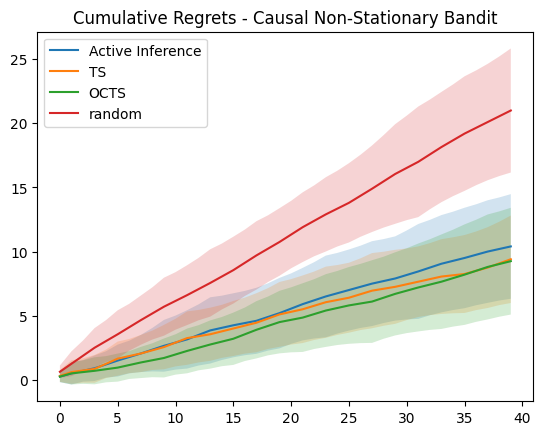

In [182]:
def plot_cumulative_regrets_causal_bandit():
    PARAMS = [0.9,0.1,0.6,0.4, 0.5, 0.5, 0.6]
    PARAMS2 = np.zeros_like(PARAMS) #[0.3, 0.7, 0.3, 0.7, 0.5, 0.5, 0.6]
    ACTIONS = [("X",0),("X",1)]

    agents = [AIAgent(ACTIONS), TSAgent(ACTIONS), OCTSAgent(ACTIONS), Agent(ACTIONS)]#, AIBanditAgent(ACTIONS, PARAMS[4])]
    envs = [BernoulliCausalBandit(PARAMS) for i in range(len(agents))]
    envs2 = [BernoulliCausalBandit(PARAMS2) for i in range(len(agents))]
    
    regrets = [[] for i in range(len(agents))]

    for i in tqdm(range(len(agents))): 
        current_agent = agents[i]
        current_env = envs[i]
        current_env2 = envs[i]
        current_regret = regrets[i]

        previous_action = ACTIONS[np.random.randint(2)]

        for t in range(100):
            observation = current_env.reset()
            for k in range(20):
                if (i==0):
                    action = current_agent.choose_action(observation, previous_action)
                    previous_action = action
                else:
                    action = current_agent.choose_action(observation)
                observation, reward, done, info = current_env.step(action)
            current_regret.append(current_env.regrets)

            #current_env = envs2[i]
            for k in range(20):
                
                if (i==0):
                    action = current_agent.choose_action(observation, previous_action)
                    previous_action = action
                else:
                    action = current_agent.choose_action(observation)
                observation, reward, done, info = current_env.step(action)
            current_regret.append(current_env.regrets)
        
        current_cumul_reg = np.cumsum(current_regret, axis=0)
        _,m = np.shape(current_cumul_reg)
        means = np.asarray([np.mean(current_cumul_reg[j, :]) for j in range(m)])
        stds = np.asarray([np.std(current_cumul_reg[j, :]) for j in range(m)])
        x = np.arange(m)

        plt.plot(x, means)
        plt.fill_between(x, means - stds, means + stds, alpha = 0.2, label='_nolegend_')

    plt.legend(['Active Inference',  'TS', 'OCTS',  'random', 'AI Bandit'])
    plt.title('Cumulative Regrets - Causal Non-Stationary Bandit')

plot_cumulative_regrets_causal_bandit()

Calcul de significance

In [68]:
N = 5000
def generate_cumulative_regrets_changing_causal_bandit():
    PARAMS = [0.9,0.1,0.6,0.4, 0.5]
    ACTIONS = [("X",0),("X",1)]

    agents = [AIAgent(ACTIONS), TSAgent(ACTIONS), OCTSAgent(ACTIONS), Agent(ACTIONS)]#, AIBanditAgent(ACTIONS, PARAMS[4])]
    envs = [BernoulliChangingCausalBandit(PARAMS) for i in range(len(agents))]
    regrets = [[] for i in range(len(agents))]
    final_regrets = [[] for _ in agents]  # Initialize final_regrets to store the final regret for each agent

    for i in tqdm(range(len(agents))):

        agents = [AIAgent(ACTIONS), TSAgent(ACTIONS), OCTSAgent(ACTIONS), Agent(ACTIONS)]
        current_agent = agents[i]
        current_env = envs[i]
        current_regret = []  # Initialize an empty list to store the regrets for each trial

        previous_action = ACTIONS[np.random.randint(2)]

        for t in range(N):
            observation = current_env.reset()
            for k in range(40):
                if (i == 0):
                    action = current_agent.choose_action(observation, previous_action)
                    previous_action = action
                else:
                    action = current_agent.choose_action(observation)
                observation, reward, done, info = current_env.step(action)
            
            # Append the final cumulative regret after 40 steps
            current_regret.append(np.sum(current_env.regrets))
        
        #current_cumul_regret = np.cumsum(current_regret, axis=0)
        
        # Convert the list of regrets to a numpy array
        current_regret_array = np.array(current_regret)

        # Store the final regrets for the current agent
        final_regrets[i] = current_regret_array

    return np.array(final_regrets)

final_regrets = generate_cumulative_regrets_changing_causal_bandit()




100%|██████████| 4/4 [00:46<00:00, 11.52s/it]


In [69]:

flattened_final_regrets =final_regrets.reshape(4,N)

# Les données pour chaque algorithme
data_algo1 = flattened_final_regrets[0, :]
data_algo2 = flattened_final_regrets[1, :]
data_algo3 = flattened_final_regrets[2, :]
data_algo4 = flattened_final_regrets[3, :]


# Test de normalité (par exemple, test de Shapiro-Wilk)
_, p1 = stats.shapiro(data_algo1)
_, p2 = stats.shapiro(data_algo2)
_, p3 = stats.shapiro(data_algo3)
_, p4 = stats.shapiro(data_algo4)

# Si toutes les données sont normalement distribuées (p > 0.05)
if p1 > 0.05 and p2 > 0.05 and p3 > 0.05 and p4 > 0.05:
    # Test ANOVA
    f_value, p_value = stats.f_oneway(data_algo1, data_algo2, data_algo3, data_algo4)
    if p_value < 0.05:
        # Test post-hoc
        all_data = np.concatenate([data_algo1, data_algo2, data_algo3, data_algo4])
        groups = ['algo1']*N + ['algo2']*N + ['algo3']*N + ['algo4']*N
        tukey_result = pairwise_tukeyhsd(all_data, groups, alpha=0.05)
        print(tukey_result.summary())
else:
    # Utiliser un test non-paramétrique si les données ne sont pas normales
    # Par exemple, le test de Kruskal-Wallis suivi de tests post-hoc appropriés
    #Test de Kruskal-Wallis
    kruskal_stat, p_value = stats.kruskal(data_algo1, data_algo2, data_algo3, data_algo4)

    print("Kruskal-Wallis H-statistic:", kruskal_stat)
    print("P-value:", p_value)



Kruskal-Wallis H-statistic: 11375.781084421415
P-value: 0.0


In [70]:
# Définir les paires d'algorithmes à comparer
pairs = [(data_algo1, data_algo2), (data_algo1, data_algo3), (data_algo1, data_algo4),
         (data_algo2, data_algo3), (data_algo2, data_algo4), (data_algo3, data_algo4)]

# Correction de Bonferroni
alpha = 0.05 / len(pairs)

# Effectuer le test de Mann-Whitney pour chaque paire
for i, (group1, group2) in enumerate(pairs):
    stat, p = stats.mannwhitneyu(group1, group2)
    if p < alpha:
        print(f"Différence significative entre le groupe {i+1} (p={p})")


Différence significative entre le groupe 3 (p=0.0)
Différence significative entre le groupe 5 (p=0.0)
Différence significative entre le groupe 6 (p=0.0)


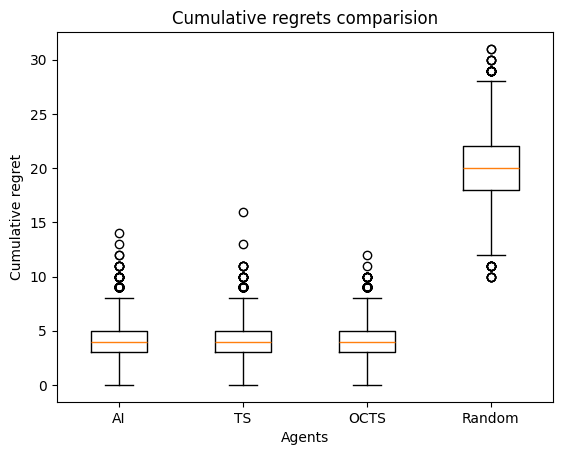

In [71]:
# Créer un boxplot
data_to_plot = [data_algo1, data_algo2, data_algo3, data_algo4]
plt.boxplot(data_to_plot)

plt.title('Cumulative regrets comparision')
plt.ylabel('Cumulative regret')
plt.xlabel('Agents')
plt.xticks([1, 2, 3, 4], ['AI', 'TS', 'OCTS', 'Random'])

# Afficher le plot
plt.show()


In [72]:
# Calcul des médianes
median_algo1 = np.median(data_algo1)
median_algo2 = np.median(data_algo2)
median_algo3 = np.median(data_algo3)
median_algo4 = np.median(data_algo4)

# Création d'un DataFrame pour afficher les résultats dans un tableau
df_medians = pd.DataFrame({
    'Algorithme': ['Algo1', 'Algo2', 'Algo3', 'Algo4'],
    'Médiane': [median_algo1, median_algo2, median_algo3, median_algo4]
})

# Affichage du tableau
print(df_medians)


  Algorithme  Médiane
0      Algo1      4.0
1      Algo2      4.0
2      Algo3      4.0
3      Algo4     20.0


### Experiment 4 : Causal bandit with manipulable confounder

100%|██████████| 4/4 [00:09<00:00,  2.25s/it]


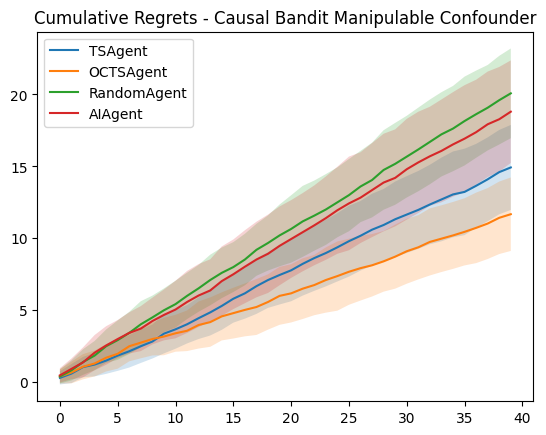

In [151]:
def plot_cumulative_regrets_causal_bandit():
    PARAMS = [0.9,0.1,0.6,0.4, 0.5, 0.5, 0.6]
    ACTIONS = [("X",0),("X",1), ("Z", 0), ("Z", 1)]

    agents = [ TSAgent(ACTIONS), OCTSAgent(ACTIONS), Agent(ACTIONS), AIAgent(ACTIONS)]#, AIBanditAgent(ACTIONS, PARAMS[4])]
    envs = [BernoulliCausalBandit(PARAMS) for i in range(len(agents))]
    regrets = [[] for i in range(len(agents))]

    for i in tqdm(range(len(agents))): 
        current_agent = agents[i]
        current_env = envs[i]
        current_regret = regrets[i]

        previous_action = ACTIONS[np.random.randint(4)]

        for t in range(1000):
            observation = current_env.reset()
            for k in range(40):
                if (current_agent.__name__() == "AIAgent"):
                    action = current_agent.choose_action(observation, previous_action)
                    previous_action = action
                    
                else:
                    action = current_agent.choose_action(observation)
                observation, reward, done, info = current_env.step(action)
            current_regret.append(current_env.regrets)
        
        current_cumul_reg = np.cumsum(current_regret, axis=0)
        _,m = np.shape(current_cumul_reg)
        means = np.asarray([np.mean(current_cumul_reg[j, :]) for j in range(m)])
        stds = np.asarray([np.std(current_cumul_reg[j, :]) for j in range(m)])
        x = np.arange(m)

        plt.plot(x, means)
        plt.fill_between(x, means - stds, means + stds, alpha = 0.2, label='_nolegend_')

    plt.legend([agent.__name__() for agent in agents])
    plt.title('Cumulative Regrets - Causal Bandit Manipulable Confounder')

plot_cumulative_regrets_causal_bandit()

Random Agent


100%|██████████| 1000/1000 [00:01<00:00, 532.14it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:01<00:00, 546.35it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:01<00:00, 535.19it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:01<00:00, 541.70it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


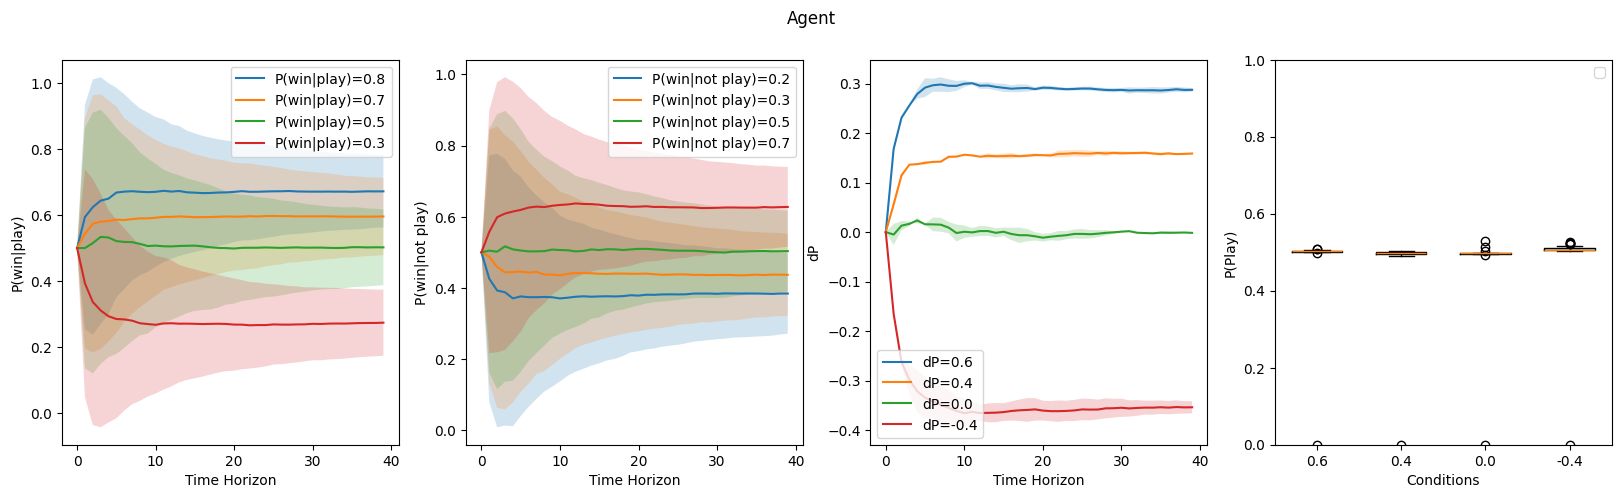

In [152]:
ACTIONS = [("X",0),("X",1), ("Z", 0), ("Z", 1)]
plot_prob(Agent, BernoulliCausalBandit, ACTIONS,  switch=0.8, reset_agent=True)

TSAgent

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:04<00:00, 237.47it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:04<00:00, 240.04it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:04<00:00, 246.73it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:04<00:00, 245.53it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


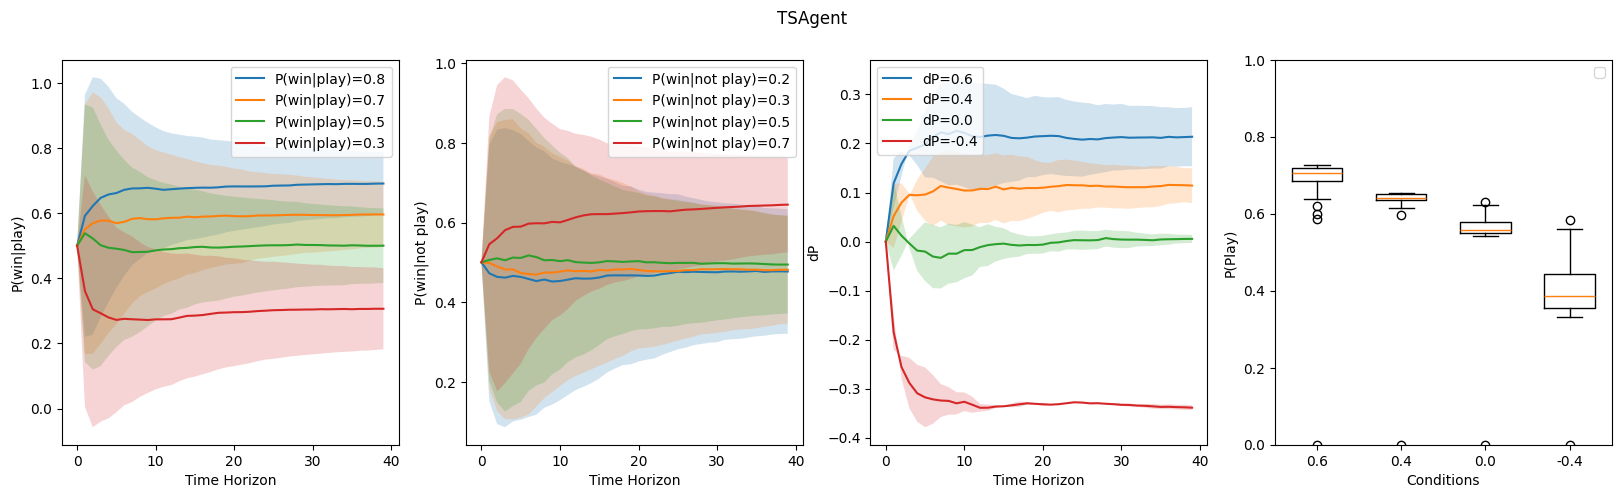

In [153]:
ACTIONS = [("X",0),("X",1), ("Z", 0), ("Z", 1)]
plot_prob(TSAgent, BernoulliCausalBandit, ACTIONS,  switch=0.8, reset_agent=True)

OCTSAgent

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:04<00:00, 241.65it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:04<00:00, 245.53it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:04<00:00, 246.31it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:04<00:00, 249.36it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


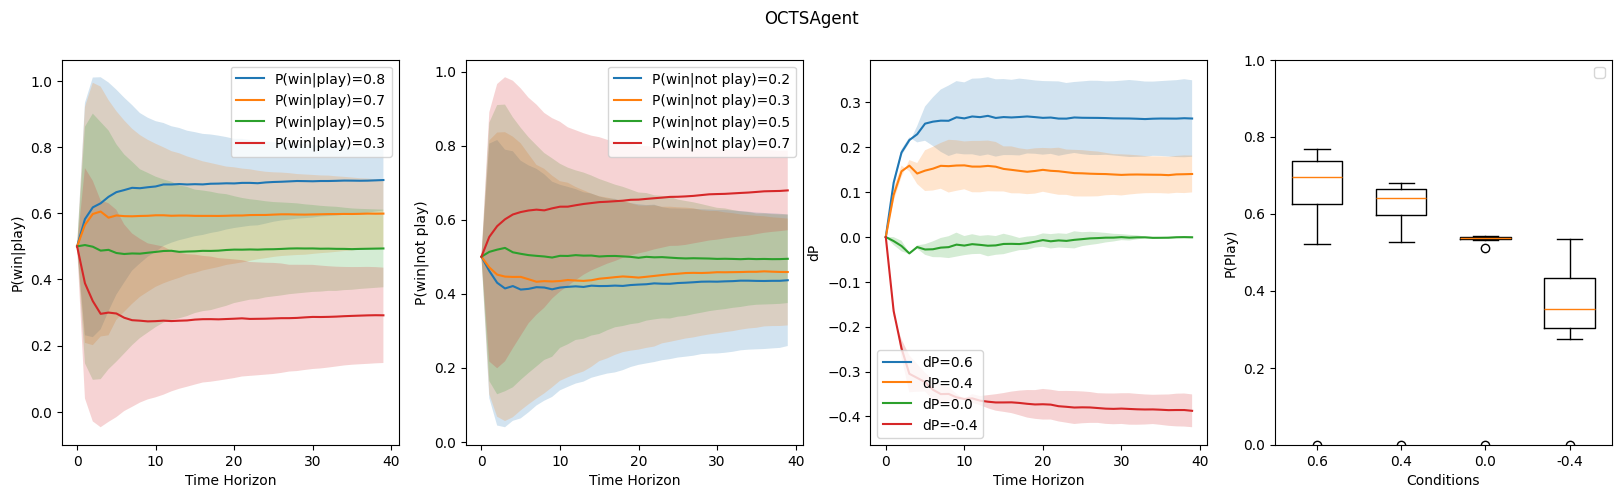

In [154]:
ACTIONS = [("X",0),("X",1), ("Z", 0), ("Z", 1)]
plot_prob(OCTSAgent, BernoulliCausalBandit, ACTIONS,  switch=0.8, reset_agent=True)

AIAgent

100%|██████████| 1000/1000 [00:02<00:00, 496.53it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:01<00:00, 505.11it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:01<00:00, 504.20it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [00:01<00:00, 516.94it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


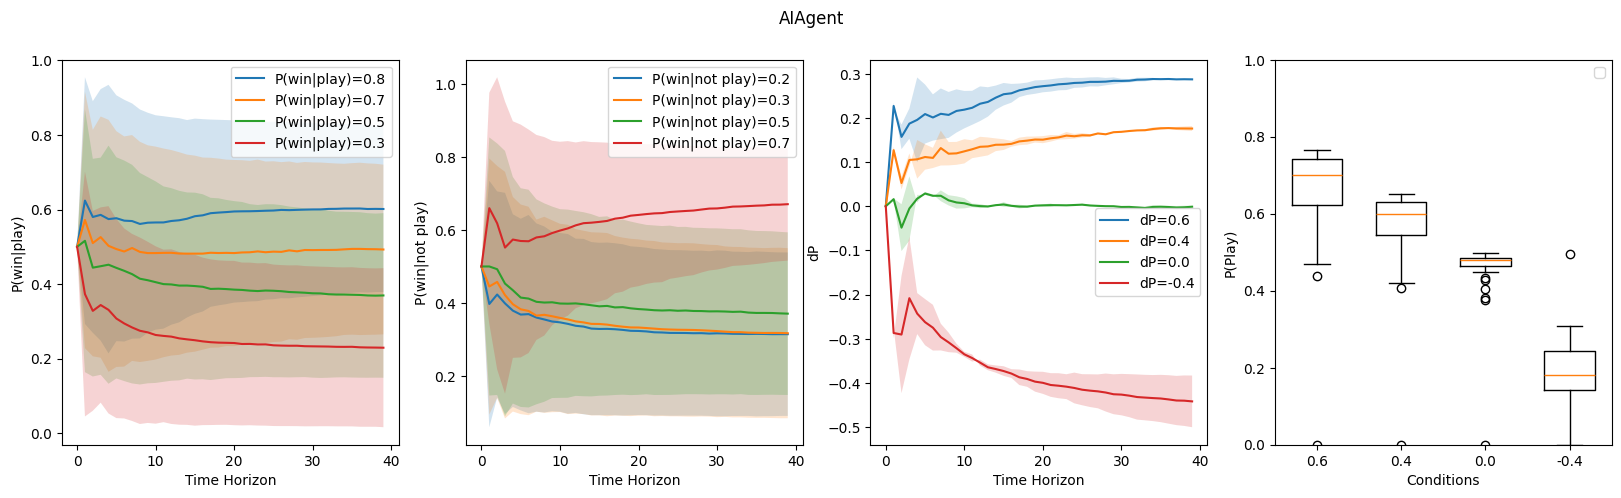

In [155]:
ACTIONS = [("X",0),("X",1), ("Z", 0), ("Z", 1)]
plot_prob(AIAgent, BernoulliCausalBandit, ACTIONS,  switch=0.8, reset_agent=True)

Calcul de significance

In [156]:
N = 5000
def generate_cumulative_regrets_causal_bandit_exp4():
    PARAMS = [0.9,0.1,0.6,0.4, 0.5, 0.5, 0.6]
    ACTIONS = [("X",0),("X",1), ("Z", 0), ("Z", 1)]

    agents = [AIAgent(ACTIONS), TSAgent(ACTIONS), OCTSAgent(ACTIONS), Agent(ACTIONS)]#, AIBanditAgent(ACTIONS, PARAMS[4])]
    envs = [BernoulliCausalBandit(PARAMS) for i in range(len(agents))]
    regrets = [[] for i in range(len(agents))]
    final_regrets = [[] for _ in agents]  # Initialize final_regrets to store the final regret for each agent

    for i in (range(len(agents))):

        agents = [AIAgent(ACTIONS), TSAgent(ACTIONS), OCTSAgent(ACTIONS), Agent(ACTIONS)]
        current_agent = agents[i]
        current_env = envs[i]
        current_regret = []  # Initialize an empty list to store the regrets for each trial

        previous_action = ACTIONS[np.random.randint(4)]

        for t in tqdm(range(N)):
            observation = current_env.reset()
            for k in range(40):
                if (current_agent.__name__() == "AIAgent"):
                    action = current_agent.choose_action(observation, previous_action)
                    previous_action = action
                    
                else:
                    action = current_agent.choose_action(observation)
                observation, reward, done, info = current_env.step(action)
            current_regret.append(np.sum(current_env.regrets))
   
        #current_cumul_regret = np.cumsum(current_regret, axis=0)
        
        # Convert the list of regrets to a numpy array
        current_regret_array = np.array(current_regret)

        # Store the final regrets for the current agent
        final_regrets[i] = current_regret_array

    return np.array(final_regrets)

final_regrets = generate_cumulative_regrets_causal_bandit_exp4()

100%|██████████| 5000/5000 [00:06<00:00, 808.49it/s]


In [157]:

flattened_final_regrets =final_regrets.reshape(4,N)

# Les données pour chaque algorithme
data_algo1 = flattened_final_regrets[0, :]
data_algo2 = flattened_final_regrets[1, :]
data_algo3 = flattened_final_regrets[2, :]
data_algo4 = flattened_final_regrets[3, :]


# Test de normalité (par exemple, test de Shapiro-Wilk)
_, p1 = stats.shapiro(data_algo1)
_, p2 = stats.shapiro(data_algo2)
_, p3 = stats.shapiro(data_algo3)
_, p4 = stats.shapiro(data_algo4)

# Si toutes les données sont normalement distribuées (p > 0.05)
if p1 > 0.05 and p2 > 0.05 and p3 > 0.05 and p4 > 0.05:
    # Test ANOVA
    f_value, p_value = stats.f_oneway(data_algo1, data_algo2, data_algo3, data_algo4)
    if p_value < 0.05:
        # Test post-hoc
        all_data = np.concatenate([data_algo1, data_algo2, data_algo3, data_algo4])
        groups = ['algo1']*N + ['algo2']*N + ['algo3']*N + ['algo4']*N
        tukey_result = pairwise_tukeyhsd(all_data, groups, alpha=0.05)
        print(tukey_result.summary())
else:
    # Utiliser un test non-paramétrique si les données ne sont pas normales
    # Par exemple, le test de Kruskal-Wallis suivi de tests post-hoc appropriés
    #Test de Kruskal-Wallis
    kruskal_stat, p_value = stats.kruskal(data_algo1, data_algo2, data_algo3, data_algo4)

    print("Kruskal-Wallis H-statistic:", kruskal_stat)
    print("P-value:", p_value)



Kruskal-Wallis H-statistic: 10634.120023032217
P-value: 0.0


In [158]:
# Définir les paires d'algorithmes à comparer
pairs = [(data_algo1, data_algo2), (data_algo1, data_algo3), (data_algo1, data_algo4),
         (data_algo2, data_algo3), (data_algo2, data_algo4), (data_algo3, data_algo4)]

# Correction de Bonferroni
alpha = 0.05 / len(pairs)

# Effectuer le test de Mann-Whitney pour chaque paire
for i, (group1, group2) in enumerate(pairs):
    stat, p = stats.mannwhitneyu(group1, group2)
    if p < alpha:
        print(f"Différence significative entre le groupe {i+1} (p={p})")


Différence significative entre le groupe 1 (p=0.0)
Différence significative entre le groupe 2 (p=0.0)
Différence significative entre le groupe 3 (p=1.0235210193541511e-20)
Différence significative entre le groupe 4 (p=3.228281832991043e-134)
Différence significative entre le groupe 5 (p=0.0)
Différence significative entre le groupe 6 (p=0.0)


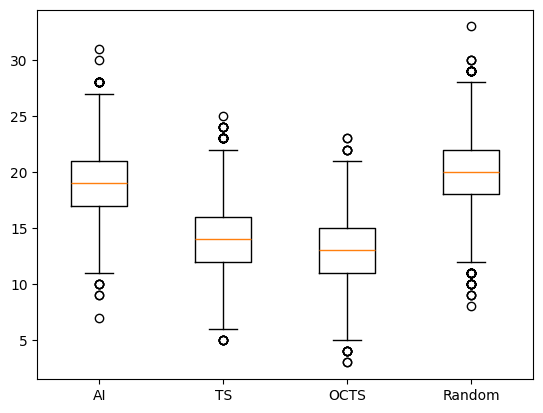

In [159]:
# Créer un boxplot
data_to_plot = [data_algo1, data_algo2, data_algo3, data_algo4]
plt.boxplot(data_to_plot)

#plt.title('Cumulative regrets comparison')
#plt.ylabel('Cumulative regrets')
#plt.xlabel('Agents')
plt.xticks([1, 2, 3, 4], ['AI', 'TS', 'OCTS', 'Random'])

# Afficher le plot
plt.show()


In [78]:
# Calcul des médianes
median_algo1 = np.median(data_algo1)
median_algo2 = np.median(data_algo2)
median_algo3 = np.median(data_algo3)
median_algo4 = np.median(data_algo4)

# Création d'un DataFrame pour afficher les résultats dans un tableau
df_medians = pd.DataFrame({
    'Algorithme': ['Algo1', 'Algo2', 'Algo3', 'Algo4'],
    'Médiane': [median_algo1, median_algo2, median_algo3, median_algo4]
})

# Affichage du tableau
print(df_medians)


  Algorithme  Médiane
0      Algo1     20.0
1      Algo2     14.0
2      Algo3     13.0
3      Algo4     20.0


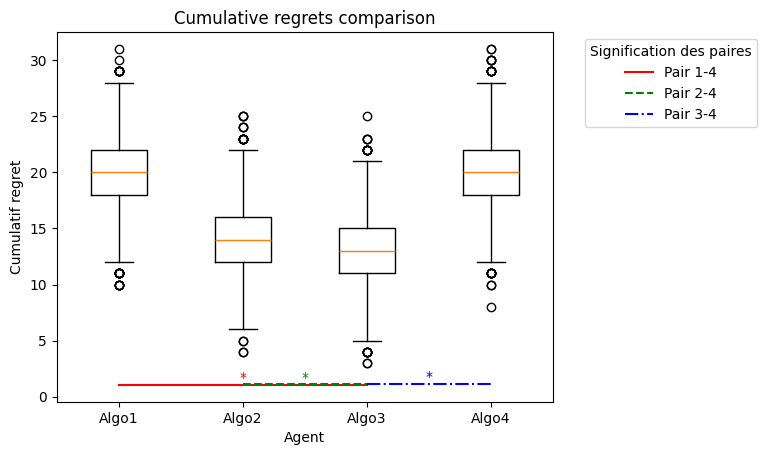

In [79]:

# Créer un boxplot
data_to_plot = [data_algo1, data_algo2, data_algo3, data_algo4]
plt.boxplot(data_to_plot)

plt.title('Cumulative regrets comparison')
plt.ylabel('Cumulatif regret')
plt.xlabel('Agent')
plt.xticks([1, 2, 3, 4], ['Algo1', 'Algo2', 'Algo3', 'Algo4'])

# Ajouter des annotations
significant_pairs = [(1, 3), (2, 3), (3, 4)]  # Exemple: Groupes 1 et 3, 2 et 3, 3 et 4 diffèrent
max_y = max(max(data) for data in data_to_plot) * 1.1  # Calculez une valeur de y pour dessiner les lignes
# Les labels pour chaque paire
pair_labels = ['Pair 1-4', 'Pair 2-4', 'Pair 3-4']

colors = ['red', 'green', 'blue', 'purple']
linestyles = ['-', '--', '-.', ':']
# Hauteur de base pour dessiner les lignes de signification
y_height = 1.05
line_objects = []

for idx, pair in enumerate(significant_pairs):
  # Choisissez une couleur et un style basés sur l'index
    color = colors[idx % len(colors)]
    linestyle = linestyles[idx % len(linestyles)]
    
    # Dessiner une ligne entre les paires
    line, = plt.plot(pair, [y_height, y_height], color=color, lw=1.5, linestyle=linestyle, label=pair_labels[idx])
    line_objects.append(line)

    # Ajouter une étoile pour la signification
    star_x = sum(pair) / 2
    plt.text(star_x, y_height, '*', ha='center', va='bottom', color=color)
    
    # Augmentez la hauteur pour la prochaine ligne pour éviter de chevaucher
    y_height += 0.05

# ... (le reste de votre code pour préparer le boxplot)

# Filtrer les objets de ligne pour exclure ceux avec un label qui commence par '_'
filtered_line_objects = [obj for obj in line_objects if not obj.get_label().startswith('_')]

# Ajouter la légende avec les objets filtrés
plt.legend(handles=filtered_line_objects, bbox_to_anchor=(1.05, 1), loc='upper left', title="Signification des paires")

# ... (le reste de votre code pour afficher le graphique)

plt.show()


In [196]:
ACTIONS = [("X",0),("X",1), ("Z", 0), ("Z", 1)]

dfts = get_prob(TSAgent, BernoulliCausalBandit, actions= ACTIONS,  reset_agent=True, switch=0.9)
dfocts = get_prob(OCTSAgent, BernoulliCausalBandit, actions= ACTIONS,  reset_agent=True, switch=0.9)
dfag = get_prob(Agent, BernoulliCausalBandit, actions= ACTIONS,  reset_agent=True, switch=0.9)
dfai = get_prob(AIAgent, BernoulliCausalBandit, actions= ACTIONS,  reset_agent=True, switch=0.9)

100%|██████████| 100/100 [00:00<00:00, 529.43it/s]


In [197]:
combined_df = pd.concat([dfts[['P_win_play', 'Agent']],
                         dfocts[['P_win_play', 'Agent']], 
                         dfag[['P_win_play', 'Agent']], 
                         dfai[['P_win_play', 'Agent']]])

combined_df = combined_df.dropna(subset=['P_win_play'])

In [198]:
# Group the 'P_win_play' values by the 'group' column
combined_df['Agent'] = combined_df['Agent'].astype(str)

groups = combined_df.groupby('Agent')['P_win_play'].apply(list)

# Perform Levene's test
stat, p = levene(*groups)

print('Levene’s test statistic:', stat)
print('p-value:', p)


Levene’s test statistic: 39.52428785736762
p-value: 1.884778222775567e-25


In [199]:

# Assume combined_df is your data frame with all groups combined and 'Agent' is the column indicating the group to which each observation belongs.

# Perform Levene's test for each pair of groups and store results.
pairs = []
for i, group1 in enumerate(combined_df['Agent'].unique()):
    for j, group2 in enumerate(combined_df['Agent'].unique()):
        if i < j:  # This ensures that each pair is only tested once.
            data1 = combined_df[combined_df['Agent'] == group1]['P_win_play'].dropna()
            data2 = combined_df[combined_df['Agent'] == group2]['P_win_play'].dropna()
            stat, p = levene(data1, data2)
            pairs.append((group1, group2, stat, p))

# Convert the results to a DataFrame.
pairwise_results = pd.DataFrame(pairs, columns=['Group1', 'Group2', 'Stat', 'P'])

# Apply Bonferroni correction for multiple comparisons.
pairwise_results['P_adjusted'] = pairwise_results['P'] * (len(pairs) / 2)  # Total tests divided by 2 because pairs are mirrored.
pairwise_results['P_adjusted'] = pairwise_results['P_adjusted'].clip(upper=1)  # P-values can't be greater than 1.

print(pairwise_results)


                         Group1                        Group2        Stat  \
0    <class '__main__.TSAgent'>  <class '__main__.OCTSAgent'>    7.654120   
1    <class '__main__.TSAgent'>      <class '__main__.Agent'>  104.156433   
2    <class '__main__.TSAgent'>    <class '__main__.AIAgent'>    2.349116   
3  <class '__main__.OCTSAgent'>      <class '__main__.Agent'>   62.766640   
4  <class '__main__.OCTSAgent'>    <class '__main__.AIAgent'>    0.937345   
5      <class '__main__.Agent'>    <class '__main__.AIAgent'>   64.387194   

              P    P_adjusted  
0  5.673899e-03  1.702170e-02  
1  2.535977e-24  7.607931e-24  
2  1.253903e-01  3.761710e-01  
3  2.579171e-15  7.737512e-15  
4  3.329859e-01  9.989578e-01  
5  1.172291e-15  3.516874e-15  


### Experiment 5: Adding observation

100%|██████████| 4/4 [00:50<00:00, 12.62s/it]


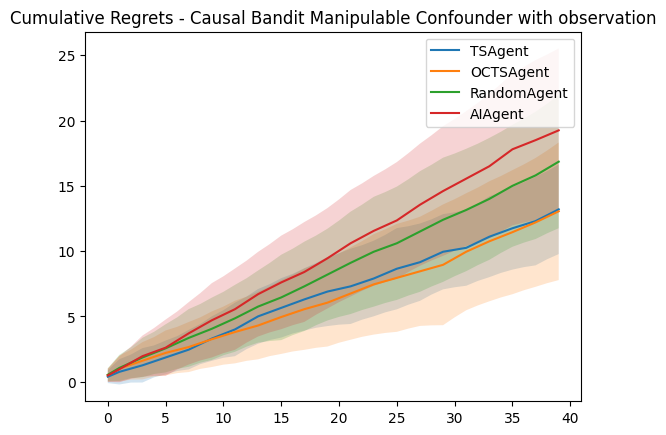

In [164]:
def plot_cumulative_regrets_causal_bandit_obs():
    PARAMS = [0.9,0.1,0.6,0.4, 0.5, 0.9, 0.1]
    ACTIONS = [("X",0),("X",1), ("Z", 0), ("Z", 1)]

    agents = [ TSAgent(ACTIONS), OCTSAgent(ACTIONS), Agent(ACTIONS), AIAgent(ACTIONS)]#, AIBanditAgent(ACTIONS, PARAMS[4])]
    envs = [BernoulliCausalBandit(PARAMS) for i in range(len(agents))]
    regrets = [[] for i in range(len(agents))]

    for i in tqdm(range(len(agents))): 
        current_agent = agents[i]
        current_env = envs[i]
        current_regret = regrets[i]

        previous_action = ACTIONS[np.random.randint(4)]

        for t in range(5000):
            observation = current_env.reset()

            for k in range(20):
                #action = current_agent.choose_action(observation)
                #observation, reward, done, info = current_env.step({})
                if (str(current_agent).find("AIAgent") > 0 ):
                    action = current_agent.choose_action(observation, previous_action)
                    previous_action = action
                else:
                    action = current_agent.choose_action(observation)
                observation, reward, done, info = current_env.step({})
            current_regret.append(current_env.regrets)
                
            for k in range(20):    
                #action = current_agent.choose_action(observation)
                #observation, reward, done, info = current_env.step(action)
                if (str(current_agent).find("AIAgent") > 0 ):
                    action = current_agent.choose_action(observation, previous_action)
                    previous_action = action
                else:
                    action = current_agent.choose_action(observation)
                observation, reward, done, info = current_env.step(action)
            current_regret.append(current_env.regrets)
        
        current_cumul_reg = np.cumsum(current_regret, axis=0)
        _,m = np.shape(current_cumul_reg)
        means = np.asarray([np.mean(current_cumul_reg[j, :]) for j in range(m)])
        stds = np.asarray([np.std(current_cumul_reg[j, :]) for j in range(m)])
        x = np.arange(m)

        plt.plot(x, means)
        plt.fill_between(x, means - stds, means + stds, alpha = 0.2, label='_nolegend_')

    plt.legend([agent.__name__() for agent in agents])
    plt.title('Cumulative Regrets - Causal Bandit Manipulable Confounder with observation')


plot_cumulative_regrets_causal_bandit_obs()

Calcul de significance


In [165]:
N = 5000
def generate_cumulative_regrets_causal_bandit5():
    PARAMS = [0.9,0.1,0.6,0.4, 0.5, 0.9, 0.1]
    ACTIONS = [("X",0),("X",1), ("Z", 0), ("Z", 1)] 
    agents = [ TSAgent(ACTIONS), OCTSAgent(ACTIONS), Agent(ACTIONS), AIAgent(ACTIONS)]#, AIBanditAgent(ACTIONS, PARAMS[4])]
    envs = [BernoulliCausalBandit(PARAMS) for i in range(len(agents))]
    regrets = [[] for i in range(len(agents))]
    final_regrets = [[] for _ in agents]  # Initialize final_regrets to store the final regret for each agent

    for i in tqdm(range(len(agents))):

        agents = [ TSAgent(ACTIONS), OCTSAgent(ACTIONS), Agent(ACTIONS), AIAgent(ACTIONS)]#, AIBanditAgent(ACTIONS, PARAMS[4])]
        current_agent = agents[i]
        current_env = envs[i]
        current_regret = []  # Initialize an empty list to store the regrets for each trial

        previous_action = ACTIONS[np.random.randint(4)]

        for t in range(N):
            observation = current_env.reset()

            for k in range(20):
                if (str(current_agent).find("AIAgent") > 0 ):
                    action = current_agent.choose_action(observation, previous_action)
                    previous_action = action
                else:
                    action = current_agent.choose_action(observation)
                observation, reward, done, info = current_env.step({})
            #current_regret.append(current_env.regrets)
                 
            for k in range(20):    
                if (str(current_agent).find("AIAgent") > 0 ):
                    action = current_agent.choose_action(observation, previous_action)
                    previous_action = action
                else:
                    action = current_agent.choose_action(observation)
                observation, reward, done, info = current_env.step(action)
             #current_regret.append(current_env.regrets)
          
            # Append the final cumulative regret after 40 steps
            current_regret.append(np.sum(current_env.regrets))
        
        #current_cumul_regret = np.cumsum(current_regret, axis=0)
        
        # Convert the list of regrets to a numpy array
        current_regret_array = np.array(current_regret)

        # Store the final regrets for the current agent
        final_regrets[i] = current_regret_array

    return np.array(final_regrets)

final_regrets = generate_cumulative_regrets_causal_bandit5()





100%|██████████| 4/4 [00:51<00:00, 12.81s/it]


In [166]:

flattened_final_regrets =final_regrets.reshape(4,N)

# Les données pour chaque algorithme
data_algo1 = flattened_final_regrets[0, :]
data_algo2 = flattened_final_regrets[1, :]
data_algo3 = flattened_final_regrets[2, :]
data_algo4 = flattened_final_regrets[3, :]


# Test de normalité (par exemple, test de Shapiro-Wilk)
_, p1 = stats.shapiro(data_algo1)
_, p2 = stats.shapiro(data_algo2)
_, p3 = stats.shapiro(data_algo3)
_, p4 = stats.shapiro(data_algo4)

# Si toutes les données sont normalement distribuées (p > 0.05)
if p1 > 0.05 and p2 > 0.05 and p3 > 0.05: # and p4 > 0.05:
    # Test ANOVA
    f_value, p_value = stats.f_oneway(data_algo1, data_algo2, data_algo3)
    if p_value < 0.05:
        # Test post-hoc
        all_data = np.concatenate([data_algo1, data_algo2, data_algo3, data_algo4])
        groups = ['algo1']*N + ['algo2']*N + ['algo3']*N + ['algo4']*N
        tukey_result = pairwise_tukeyhsd(all_data, groups, alpha=0.05)
        print(tukey_result.summary())
else:
    # Utiliser un test non-paramétrique si les données ne sont pas normales
    # Par exemple, le test de Kruskal-Wallis suivi de tests post-hoc appropriés
    #Test de Kruskal-Wallis
    kruskal_stat, p_value = stats.kruskal(data_algo1, data_algo2, data_algo3, data_algo4)

    print("Kruskal-Wallis H-statistic:", kruskal_stat)
    print("P-value:", p_value)



Kruskal-Wallis H-statistic: 11596.86183850835
P-value: 0.0


In [167]:
# Définir les paires d'algorithmes à comparer
pairs = [(data_algo1, data_algo2), (data_algo1, data_algo3), 
         (data_algo2, data_algo3),]

# Correction de Bonferroni
alpha = 0.05 / len(pairs)

# Effectuer le test de Mann-Whitney pour chaque paire
for i, (group1, group2) in enumerate(pairs):
    stat, p = stats.mannwhitneyu(group1, group2)
    if p < alpha:
        print(f"Différence significative entre le groupe {i+1} (p={p})")


Différence significative entre le groupe 1 (p=3.005027073549657e-10)
Différence significative entre le groupe 2 (p=0.0)
Différence significative entre le groupe 3 (p=0.0)


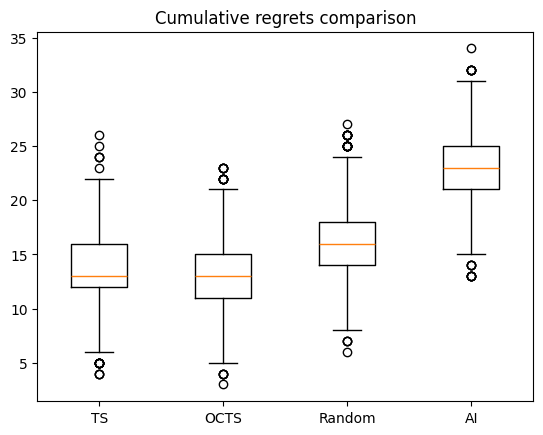

In [170]:
# Créer un boxplot
data_to_plot = [data_algo1, data_algo2, data_algo3, data_algo4]
plt.boxplot(data_to_plot)

plt.title('Cumulative regrets comparison')
#plt.ylabel('Cumulative regrets')
#plt.xlabel('Agents')
plt.xticks([1, 2, 3, 4], ['TS', 'OCTS', 'Random' ,'AI'])

# Afficher le plot
plt.show()


In [169]:
# Calcul des médianes
median_algo1 = np.median(data_algo1)
median_algo2 = np.median(data_algo2)
median_algo3 = np.median(data_algo3)
median_algo4 = np.median(data_algo4)

# Création d'un DataFrame pour afficher les résultats dans un tableau
df_medians = pd.DataFrame({
    'Algorithme': ['Algo1', 'Algo2', 'Algo3', 'Algo4'],
    'Médiane': [median_algo1, median_algo2, median_algo3, median_algo4]
})

# Affichage du tableau
print(df_medians)


  Algorithme  Médiane
0      Algo1     13.0
1      Algo2     13.0
2      Algo3     16.0
3      Algo4     23.0


In [191]:
def plot_comparison_causal_estimates_obs(actions, env, params):

    agents = [TSAgent, OCTSAgent, Agent, AIAgent]
    envs = [env(params) for i in range(len(agents))]
    
    fig, axs = plt.subplots(1, 1, figsize=(8,5))

    with warnings.catch_warnings():

        warnings.simplefilter("ignore")   

        for k in range(len(agents)):

            current_env = envs[k]

            observation = {'X': 0, 'Y': 0, 'Z': 0}

            list_pwp = []
            list_pwnp = []
            list_play = []

            for i in tqdm(range(1000)):

                current_agent = agents[k](actions)
                
                hist_observations = []
                hist_rewards = []
                hist_actions = []
                observation = current_env.reset()

                previous_action = current_agent.actions[np.random.randint(len(current_agent.actions))]

             #   for t in range(20):
             #       if (str(current_agent).find("AIAgent") > 0 ):
             #           action = current_agent.choose_action(observation, previous_action)
             #           previous_action = action
             #       else:
             #           action = current_agent.choose_action(observation)                    
             #       observation, reward, done, info = current_env.step({})
             #       hist_rewards.append(reward)
             #       hist_actions.append(action) 

                for t in range(40):

                    if (str(current_agent).find("AIAgent") > 0 ):
                        action = current_agent.choose_action(observation, previous_action)
                        previous_action = action
                    else:
                        action = current_agent.choose_action(observation)
                        
                    observation, reward, done, info = current_env.step(action)
                    hist_rewards.append(reward)
                    hist_actions.append(action)
                    

                pwp, pwnp, p_play = compute_probs(hist_rewards, hist_actions)
                list_pwp.append(pwp)
                list_pwnp.append(pwnp)
                list_play.append(p_play)

            list_pwp = np.asarray(list_pwp)
            list_pwnp = np.asarray(list_pwnp)
            _, m = np.shape(list_pwnp)
            _, m = np.shape(list_pwp)
            
            pwp_means = np.asarray(([np.nanmean(list_pwp[:,j]) for j in range(m)]))
            pwp_stds = np.asarray(([np.nanstd(list_pwp[:,j]) for j in range(m)]))
           
            pwnp_means = np.asarray(([np.nanmean(list_pwnp[:,j]) for j in range(m)]))
            pwnp_stds = np.asarray(([np.nanstd(list_pwnp[:,j]) for j in range(m)]))

            pwnp_means = np.nan_to_num(pwnp_means)
            pwnp_stds = np.nan_to_num(pwnp_stds)

            dp_means = np.nan_to_num(pwp_means - pwnp_means)
            dp_stds = np.nan_to_num(pwp_stds - pwnp_stds)

            x = np.arange(m)

            axs.plot(x, dp_means,  label="{}".format(current_agent.__name__()))
            axs.fill_between(x, dp_means-dp_stds, dp_means+dp_stds, alpha=0.2)


            #axs.plot(x, ((params[1]-params[0]))*np.ones(np.shape(x)))
            axs.set_title("dP")
            axs.legend()
    


100%|██████████| 1000/1000 [00:02<00:00, 412.93it/s]


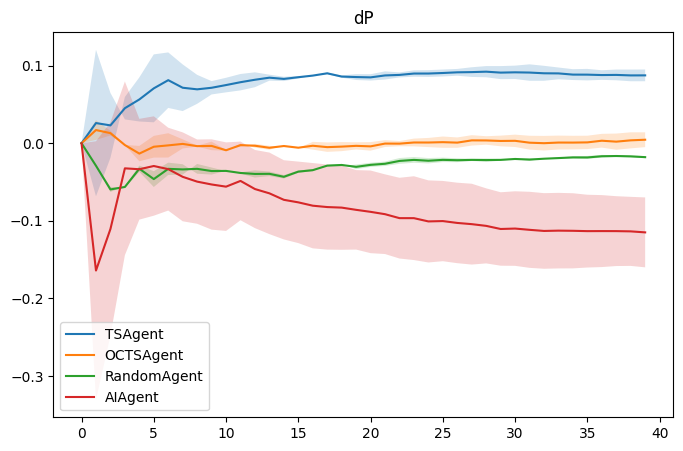

In [195]:
#PARAMS = [0.2,0.8,0.3,0.7]
PARAMS = [0.2, 0.8, 0.4, 0.6, 0.6, 0.9, 0.1]
#PARAMS = [0.9,0.1,0.9,0.1, 0.5, 0.5, 0.6]

#ACTIONS = [("X",0),("X",1)]
ACTIONS = [("X",0),("X",1), ("Z", 0), ("Z", 1)]

#ENV = BernoulliCausalBandit
ENV = BernoulliCausalBandit
plot_comparison_causal_estimates_obs(ACTIONS, ENV, PARAMS)
